# Forced Rayleigh Oscillator #

## Subharmonic case ##

Support material for the book __Perturbation Methods using Backward Error__ by Robert M. Corless and Nicolas Fillion, in preparation.

Copyright (c) 2024 Robert M. Corless

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

$\newcommand{\e}{\varepsilon}$

This notebook explores the __strongly__ forced Rayleigh oscillator
\begin{equation}
\ddot{y} - \e \dot{y}\left( 1 - \frac{4}{3}\dot{y}^2 \right) + y = 2 F\cos(\Omega t + \Phi)
\end{equation}
for $\Omega \approx 3$.

We then compute perturbation expansion up to and including the $O(\e^N)$ terms, so it has a residual $O(\e^{N+1})$.  

Define $N$ in the next cell.

In [1]:
N := 1;

kilobytes used=1808, alloc=5424, time=0.39

$$1$$

Put $\tau = \Omega t$, where $\Omega = 3 + \sigma \e/2$.

In [2]:
macro( ep=varepsilon ):
Omega := 3 + sigma*ep/2: # Traditional to include /2
Phi := 0: # Plays no role
WeaklyNonlineart := diff(y(t), t, t) 
  - ep*diff(y(t), t)*(1 - 4/3*diff(y(t), t)^2) + y(t) 
  - F*exp(I*(tau+Phi)) - F*exp(-I*(tau+Phi)) :
tmp := PDETools:-dchange( t=tau/Omega, WeaklyNonlineart, [tau]):
WeaklyNonlinear := expand( 9^(-1)*eval(tmp, y(tau,sigma,ep)=y(tau) ));

$$\frac{d^{2}}{d \tau^{2}}y \left(\tau \right)+\frac{\left(\frac{d^{2}}{d \tau^{2}}y \left(\tau \right)\right) \sigma  \varepsilon}{3}+\frac{\left(\frac{d^{2}}{d \tau^{2}}y \left(\tau \right)\right) \sigma^{2} \varepsilon^{2}}{36}-\frac{\varepsilon  \left(\frac{d}{d \tau}y \left(\tau \right)\right)}{3}+4 \varepsilon  \left(\frac{d}{d \tau}y \left(\tau \right)\right)^{3}+2 \varepsilon^{2} \left(\frac{d}{d \tau}y \left(\tau \right)\right)^{3} \sigma +\frac{\varepsilon^{3} \left(\frac{d}{d \tau}y \left(\tau \right)\right)^{3} \sigma^{2}}{3}-\frac{\varepsilon^{2} \left(\frac{d}{d \tau}y \left(\tau \right)\right) \sigma}{18}+\frac{\varepsilon^{4} \left(\frac{d}{d \tau}y \left(\tau \right)\right)^{3} \sigma^{3}}{54}+\frac{y \left(\tau \right)}{9}-\frac{F \,{\mathrm e}^{\mathrm{I} \tau}}{9}-\frac{F}{9 \,{\mathrm e}^{\mathrm{I} \tau}}$$

In [3]:
eval( WeaklyNonlinear, ep = 0);

$$\frac{d^{2}}{d \tau^{2}}y \left(\tau \right)+\frac{y \left(\tau \right)}{9}-\frac{F \,{\mathrm e}^{\mathrm{I} \tau}}{9}-\frac{F}{9 \,{\mathrm e}^{\mathrm{I} \tau}}$$

In [4]:
sol := dsolve( eval( WeaklyNonlinear, ep=0), y(tau) );

$$y \left(\tau \right) = \sin \left(\frac{\tau}{3}\right) c_{2} +\cos \left(\frac{\tau}{3}\right) c_{1} -\frac{F \cos \left(\tau \right)}{4}$$

That solution has sines and cosines.  We will work over the complex exponentials first.  Use the variable zs to keep the solution in.

In [5]:
convert( diff(F*cos(tau)/4,tau,tau) + 1/9*F*cos(tau)/4, exp );

$$-\frac{2 F \left(\frac{{\mathrm e}^{\mathrm{I} \tau}}{2}+\frac{{\mathrm e}^{\mathrm{-I} \tau}}{2}\right)}{9}$$

In [6]:
ys := Array(0 .. N): # Placeholder for secular solution terms
rs := Array(0 .. N): # Placeholder for residuals
ys[0] :=  A*exp(I*phi)*exp(I*tau/3) + A*exp(-I*phi)*exp(-I*tau/3) 
          - combine( expand( convert( F*cos(tau)/4, exp ) ), exp):
zs := ys[0];

$$A \,{\mathrm e}^{\mathrm{I} \phi} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}+A \,{\mathrm e}^{\mathrm{-I} \phi} {\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}-\frac{F \,{\mathrm e}^{\mathrm{-I} \tau}}{8}-\frac{F \,{\mathrm e}^{\mathrm{I} \tau}}{8}$$

We will work with sines and cosines in the end, but to get the secular equation we will convert to exponentials.

In [7]:
# SHOlveTerm --- solve a simple harmonic oscillator, harmonically forced
#
#
# dsolve can be inefficient at solving y'' + omega^2*y = sum of simple terms
# (probably getting bogged down in type checking or simplification
#  or its own heuristics, or perhaps it's just its generality).
# This routine attempts to do this simpler task more efficiently,
# by giving up on generality.
#
# Input: expr  : right-hand side: polynomial in sine/cos/exp only
#                with coefficients polynomials in var
#        var   : variable (usually t)
#        omega : natural frequency
#
# Processing: map over a sum of terms
#             match the terms to poly(var)*exp( I*(freq*var + phase) )
#                            or  poly(var)*sin( freq*var + phase )
#                            or  poly(var)*cos( freq*var + phase )
#
#          solve the problem y'' + omega^2*y = sum poly(var)* fn( freq*var+phase )
#
# Output: a particular solution to y'' + omega^2 = ...
#         where the rhs is a sum of polynomials in var times sin/cos/exp.
#
# Comments: dsolve would solve this, but for large expressions might take
# a seemingly unreasonable length of time to do so, and may return 
# unevaluated integrals (because it thinks the answers are too complicated).
# However, this simple routine will not succeed for unexpected inputs.
# Take your pick.

SHOlveTerm := proc( expr, var, omega )
	local A, c, fn, freq, la, m, phase, sol, term, zerp;
	description "Solve y''+ omega^2*y=expr";
    if has( expr, sin ) or has( expr, cos ) then
      # convert,exp will make cos(A) --> (exp(I*A)+exp(-I*A))/2, etc
      # expand will expand (A*exp(B) + C*exp(D))*(E*exp(F)+G*exp(H))
      # to A*E*exp(B)*exp(F) + A*G*exp(B)*exp(H) + ... 
      # combine,exp will make exp(B)*exp(F)-->exp(B+F)
      term := combine( expand( convert(expr,exp ) ), exp );
    else
      term := expr;
    end if; 
	if type( term, `+` ) then
      # Apply this procedure to each term in a sum  
	  return map( procname, term, var, omega );
	else 
      # Look for A*exp(I*(freq*var+phase))
      term := combine( term, exp );
      A := eval(term, exp=1);
      fn := normal( term/A );
      # Each term *should* be A*exp(B).  Should be.
      if normal( expr-A*fn ) <> 0 then
        error "Unexpected term type", term;
      end if;
      # Identify frequency and phase
      if match( fn=exp(I*(freq*var+phase)), var, 'la' ) then
        if eval(freq,la)^2 = omega^2 then
          # resonant case
          m := degree(A, var) + 1; # A must be polynomial
        else
          m := degree(A, var);
        end if;
        P := add( c[k]*var^k, k=0..m );
        # y = P(var)*exp(I*(freq*var+phase))
        # for P(var) a polynomial to be found.
        zerp := eval( omega^2*P + diff(P,var,var) + 2*I*freq*diff(P,var) - freq^2*P - A, la);
        sol := solve( {seq( coeff(zerp,var,k), k=0..m)}, {seq(c[k],k=0..m)} );
        # triangular system, guaranteed to have a solution
        # Throw away the redundant terms c[0]*exp(I*(freq*var+phase))
        return eval( eval( eval(P,sol), c[0]=0)*exp(I*(freq*var+phase)), la );
      else
        error "Unexpected term type, after match", term, A, fn;
      end if;
    end if;
end proc:

In [8]:
loop_start := time():
times := Array(1 .. N):
for k to N do
    residuals[k - 1] := combine(expand(
                          coeff(eval(WeaklyNonlinear, y(tau) = zs), ep, k)),
                          exp);
    newans := SHOlveTerm( residuals[k-1], tau, 1/3 );
    ys[k] := -newans;
    zs := zs + ys[k]*ep^k;
    times[k] := time();
end do:

In [9]:
zs;

$$A \,{\mathrm e}^{\mathrm{I} \phi} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}+A \,{\mathrm e}^{\mathrm{-I} \phi} {\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}-\frac{F \,{\mathrm e}^{\mathrm{-I} \tau}}{8}-\frac{F \,{\mathrm e}^{\mathrm{I} \tau}}{8}+\left(-\frac{2 A^{3} \tau  \,{\mathrm e}^{\mathrm{I} \left(\phi +\frac{\tau}{3}\right)}}{3}-\frac{2 A^{3} \tau  \,{\mathrm e}^{\mathrm{I} \left(-\phi -\frac{\tau}{3}\right)}}{3}+\frac{A \tau  \,{\mathrm e}^{\mathrm{I} \left(\phi +\frac{\tau}{3}\right)}}{6}+\frac{A \tau  \,{\mathrm e}^{\mathrm{I} \left(-\phi -\frac{\tau}{3}\right)}}{6}+\frac{3 \sigma  F \,{\mathrm e}^{\mathrm{-I} \tau}}{64}-\frac{A^{2} F \tau  \,{\mathrm e}^{\mathrm{I} \left(2 \phi -\frac{\tau}{3}\right)}}{4}+\frac{3 \sigma  F \,{\mathrm e}^{\mathrm{I} \tau}}{64}+\frac{27 \,\mathrm{I} F^{3} {\mathrm e}^{\mathrm{-I} \tau}}{1024}+\frac{9 \,\mathrm{I} F^{3} {\mathrm e}^{3 \,\mathrm{I} \tau}}{10240}-\frac{9 \,\mathrm{I} F^{3} {\mathrm e}^{-3 \,\mathrm{I} \tau}}{10240}+\frac{\mathrm{I} A^{3} {\mathrm e}^{\mathrm{I} \left(-3 \phi -\tau \right)}}{6}-\frac{\mathrm{I} A^{3} {\mathrm e}^{\mathrm{I} \left(3 \phi +\tau \right)}}{6}-\frac{27 \,\mathrm{I} F^{3} {\mathrm e}^{\mathrm{I} \tau}}{1024}-\frac{3 \,\mathrm{I} F \,{\mathrm e}^{\mathrm{-I} \tau}}{64}+\frac{3 \,\mathrm{I} F \,{\mathrm e}^{\mathrm{I} \tau}}{64}-\frac{\mathrm{I} \sigma  A \tau  \,{\mathrm e}^{\mathrm{I} \left(\phi +\frac{\tau}{3}\right)}}{18}+\frac{\mathrm{I} \sigma  A \tau  \,{\mathrm e}^{\mathrm{I} \left(-\phi -\frac{\tau}{3}\right)}}{18}-\frac{A^{2} F \tau  \,{\mathrm e}^{\mathrm{I} \left(-2 \phi +\frac{\tau}{3}\right)}}{4}-\frac{3 \,\mathrm{I} A^{2} F \,{\mathrm e}^{\mathrm{I} \tau}}{8}+\frac{3 \,\mathrm{I} A^{2} F \,{\mathrm e}^{\mathrm{-I} \tau}}{8}-\frac{3 \,\mathrm{I} F^{2} A \,{\mathrm e}^{\mathrm{I} \left(\phi -\frac{5 \tau}{3}\right)}}{128}+\frac{3 \,\mathrm{I} F^{2} A \,{\mathrm e}^{\mathrm{I} \left(-\phi -\frac{7 \tau}{3}\right)}}{256}+\frac{\mathrm{I} F \,A^{2} {\mathrm e}^{\mathrm{I} \left(2 \phi +\frac{5 \tau}{3}\right)}}{16}+\frac{3 \,\mathrm{I} F^{2} A \,{\mathrm e}^{\mathrm{I} \left(-\phi +\frac{5 \tau}{3}\right)}}{128}-\frac{3 \,\mathrm{I} F^{2} A \,{\mathrm e}^{\mathrm{I} \left(\phi +\frac{7 \tau}{3}\right)}}{256}-\frac{\mathrm{I} F \,A^{2} {\mathrm e}^{\mathrm{I} \left(-2 \phi -\frac{5 \tau}{3}\right)}}{16}-\frac{3 A \,F^{2} \tau  \,{\mathrm e}^{\mathrm{I} \left(\phi +\frac{\tau}{3}\right)}}{16}-\frac{3 A \,F^{2} \tau  \,{\mathrm e}^{\mathrm{I} \left(-\phi -\frac{\tau}{3}\right)}}{16}\right) \varepsilon$$

In [10]:
resonant := 0; # Collect all terms of the form P(t)*exp(I*t).
ze := expand( combine( expand(zs), exp ) ):
trms := [op(ze)];
for k to numelems( trms ) do
  trm := combine( trms[k], exp );
  conpart := eval(trm,exp=1); # trm = A*exp(B) we hope
  expart := normal( trm/conpart );
  if match( combine(expart,exp)=exp(I*tau/3 + phase), tau, 'la') then
    resonant := resonant + conpart*eval(exp(phase),la);
  end if;
end do:

                                                  exp(tau I)

In [11]:
ze;

$$\frac{A \,{\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}}{{\mathrm e}^{\phi  \mathrm{I}}}-\frac{F}{8 \,{\mathrm e}^{\tau  \mathrm{I}}}-\frac{F \,{\mathrm e}^{\tau  \mathrm{I}}}{8}+A \,{\mathrm e}^{\phi  \mathrm{I}} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}-\frac{\mathrm{I} \varepsilon  \sigma  A \tau  \,{\mathrm e}^{\phi  \mathrm{I}} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}}{18}+\frac{\mathrm{I} \varepsilon  \sigma  A \tau  \,{\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}}{18 \,{\mathrm e}^{\phi  \mathrm{I}}}+\frac{\mathrm{I} \varepsilon  \,A^{3}}{6 \left({\mathrm e}^{\phi  \mathrm{I}}\right)^{3} {\mathrm e}^{\tau  \mathrm{I}}}-\frac{2 \varepsilon  \,A^{3} \tau  \,{\mathrm e}^{\phi  \mathrm{I}} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}}{3}-\frac{2 \varepsilon  \,A^{3} \tau  \,{\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}}{3 \,{\mathrm e}^{\phi  \mathrm{I}}}+\frac{\varepsilon  A \tau  \,{\mathrm e}^{\phi  \mathrm{I}} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}}{6}+\frac{\varepsilon  A \tau  \,{\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}}{6 \,{\mathrm e}^{\phi  \mathrm{I}}}-\frac{3 \,\mathrm{I} \varepsilon  \,A^{2} F \,{\mathrm e}^{\tau  \mathrm{I}}}{8}-\frac{\mathrm{I} \varepsilon  \,A^{3} \left({\mathrm e}^{\phi  \mathrm{I}}\right)^{3} {\mathrm e}^{\tau  \mathrm{I}}}{6}+\frac{3 \,\mathrm{I} \varepsilon  \,A^{2} F}{8 \,{\mathrm e}^{\tau  \mathrm{I}}}+\frac{3 \,\mathrm{I} \varepsilon  \,F^{2} A \,{\mathrm e}^{\frac{5 \,\mathrm{I}}{3} \tau}}{128 \,{\mathrm e}^{\phi  \mathrm{I}}}-\frac{3 \,\mathrm{I} \varepsilon  \,F^{2} A \,{\mathrm e}^{\frac{7 \,\mathrm{I}}{3} \tau} {\mathrm e}^{\phi  \mathrm{I}}}{256}-\frac{\mathrm{I} \varepsilon  F \,A^{2} {\mathrm e}^{-\frac{5 \,\mathrm{I}}{3} \tau}}{16 \left({\mathrm e}^{\phi  \mathrm{I}}\right)^{2}}-\frac{3 \varepsilon  A \,F^{2} \tau  \,{\mathrm e}^{\phi  \mathrm{I}} {\mathrm e}^{\frac{\mathrm{I}}{3} \tau}}{16}-\frac{3 \varepsilon  A \,F^{2} \tau  \,{\mathrm e}^{-\frac{\mathrm{I}}{3} \tau}}{16 \,{\mathrm e}^{\phi  \mathrm{I}}}-\frac{\varepsilon  \,A^{2} F \tau  \,{\mathrm e}^{-\frac{\mathrm{I}}{3} \tau} \left({\mathrm e}^{\phi  \mathrm{I}}\right)^{2}}{4}-\frac{\varepsilon  \,A^{2} F \tau  \,{\mathrm e}^{\frac{\mathrm{I}}{3} \tau}}{4 \left({\mathrm e}^{\phi  \mathrm{I}}\right)^{2}}-\frac{3 \,\mathrm{I} \varepsilon  \,F^{2} A \,{\mathrm e}^{-\frac{5 \,\mathrm{I}}{3} \tau} {\mathrm e}^{\phi  \mathrm{I}}}{128}+\frac{3 \,\mathrm{I} \varepsilon  \,F^{2} A \,{\mathrm e}^{-\frac{7 \,\mathrm{I}}{3} \tau}}{256 \,{\mathrm e}^{\phi  \mathrm{I}}}+\frac{\mathrm{I} \varepsilon  F \,A^{2} {\mathrm e}^{\frac{5 \,\mathrm{I}}{3} \tau} \left({\mathrm e}^{\phi  \mathrm{I}}\right)^{2}}{16}+\frac{3 \varepsilon  \sigma  F}{64 \,{\mathrm e}^{\tau  \mathrm{I}}}+\frac{3 \varepsilon  \sigma  F \,{\mathrm e}^{\tau  \mathrm{I}}}{64}-\frac{27 \,\mathrm{I} \varepsilon  \,F^{3} {\mathrm e}^{\tau  \mathrm{I}}}{1024}+\frac{3 \,\mathrm{I} \varepsilon  F \,{\mathrm e}^{\tau  \mathrm{I}}}{64}-\frac{3 \,\mathrm{I} \varepsilon  F}{64 \,{\mathrm e}^{\tau  \mathrm{I}}}+\frac{27 \,\mathrm{I} \varepsilon  \,F^{3}}{1024 \,{\mathrm e}^{\tau  \mathrm{I}}}+\frac{9 \,\mathrm{I} \varepsilon  \,F^{3} \left({\mathrm e}^{\tau  \mathrm{I}}\right)^{3}}{10240}-\frac{9 \,\mathrm{I} \varepsilon  \,F^{3}}{10240 \left({\mathrm e}^{\tau  \mathrm{I}}\right)^{3}}$$

In [12]:
yA := resonant/(A*exp(I*phi));

$$\frac{A \,{\mathrm e}^{\phi  \mathrm{I}}-\frac{\mathrm{I} \varepsilon  \sigma  A \tau  \,{\mathrm e}^{\phi  \mathrm{I}}}{18}-\frac{2 \varepsilon  \,A^{3} \tau  \,{\mathrm e}^{\phi  \mathrm{I}}}{3}+\frac{\varepsilon  A \tau  \,{\mathrm e}^{\phi  \mathrm{I}}}{6}-\frac{3 \varepsilon  A \,F^{2} \tau  \,{\mathrm e}^{\phi  \mathrm{I}}}{16}-\frac{\varepsilon  \,A^{2} F \tau  \,{\mathrm e}^{-2 \,\mathrm{I} \phi}}{4}}{A \,{\mathrm e}^{\phi  \mathrm{I}}}$$

In [13]:
assumption_list := R>0, F>0, ep>0, phi::real, tau>0, A>0, sigma::real;

$$0<R$$,$$0<F$$,$$0<\varepsilon$$,$$\phi ::\mathit{real}$$,$$0<\tau$$,$$0<A$$,$$\sigma ::\mathit{real}$$

In [14]:
rhsR := simplify( Re( convert(series( diff(yA,tau)/yA,ep,N+1),polynom) ) ) 
        assuming assumption_list;

$$-\frac{\varepsilon  \left(12 A F \cos \left(3 \phi \right)+32 A^{2}+9 F^{2}-8\right)}{48}$$

We know $A=R + O(\e)$ but we need to know more, now.

In [15]:
yA := collect(yA, ep, m -> Re(m) + Im(m)*I) assuming assumption_list;
yA := combine(yA, trig);
#Now we will need to invert R = A*yA and the best way is by a real equation.  R is real and A > 0 by our choice of phi.
rhosq := series(evalc(Re(yA)^2 + Im(yA)^2), ep, N + 1);
rhosq := map(simplify, rhosq);
rhosq := convert(rhosq, polynom);
#Our equation to solve for A in terms of R and ep is
freqn := -A^2*rhosq + R^2;
#We will solve this perturbatively for A = g(R,ep).  We need the derivative, for our regular perturbation method.
eval(diff(freqn, R), ep = 0);
#So our inverse operator is 1/2R.  Now check that our initial approximation A=R is accurate enough:
series(leadterm(eval(freqn, A = R)), ep);
#So A = R is a solution to Order epsilon
#Let's use the array "Eh" to represent our terms in the A expansion.
Eh := Array(0 .. N);
#We have to put the residuals somewhere:
residEh := Array(0 .. N);
#Our initial approximation:
Eh[0] := R;
#Our running solution is initially the same as A[0] (I mean, Eh[0]).
Ehz := Eh[0];
#Regular perturbation solution of the freqn
for k to N do
    residEh[k - 1] := coeff(map(simplify, series(eval(freqn, A = Ehz), ep, k + 2)), ep, k);
    Eh[k] := residEh[k - 1]*ep^k/(2*R);
    Ehz := Ehz + Eh[k];
end do;
#Check the final residual
residEh[N] := CodeTools:-Usage(map(LargeExpressions:-Veil[K], 
  map(simplify, series(eval(freqn, A = Ehz), ep, N+2))));


           residEh[1] := 1/2304 K[1] varepsilon  + K[2] varepsilon

In [16]:
map( simplify, series( eval(freqn, A=Ehz), ep, N+2 ) ); # total mystery

        (60 R F cos(3 phi) + 27 F  + 224 R  - 24) varepsilon  + O(varepsilon )

$$\frac{R^{2} \tau^{2} \left(12 R F \cos \left(3 \phi \right)+32 R^{2}+9 F^{2}-8\right) \left(60 R F \cos \left(3 \phi \right)+27 F^{2}+224 R^{2}-24\right)}{2304} \varepsilon^{2}+\mathrm{O}\left(\varepsilon^{3}\right)$$

In [17]:
rhsR := convert( series( eval(rhsR,A=Ehz), ep, N+1), polynom ):

In [18]:
rhsR := collect( rhsR, [ep,F,R], distributed, m->combine(m,trig) ): 

In [19]:
rhsR := eval( rhsR, tau=0 ): # Empirically remove secularity here
coeff(rhsR,ep,0);

$$0$$

In [20]:
slowRderiv := R*convert( rhsR, polynom ):

In [21]:
`diff/R` := codegen[makeproc](eval(slowRderiv*'diff'('expr', 'var'), 
  [R = R(expr), phi = theta(expr),tau=expr]), parameters = [expr, var]);

proc (expr, var) R(expr)*(1/6*varepsilon-3/16*F^2*varepsilon-1/4*cos(3*theta(expr))*R(expr)*F*varepsilon-2/3*R(expr)^2*varepsilon)*diff(expr,var) end proc

In [22]:
forget(diff);
isolate( coeff( diff(R(tau),tau), ep, 1 ), cos(3*theta(tau)) );

$$\cos \left(3 \theta \left(\tau \right)\right) = -\frac{4 \left(-\frac{1}{6}+\frac{3 F^{2}}{16}+\frac{2 R \left(\tau \right)^{2}}{3}\right)}{R \left(\tau \right) F}$$

In [23]:
rhstheta := Im( 
             convert( 
               simplify( series( eval( diff(yA,tau)/yA, A=Ehz ),ep,N+1))
               ,polynom)
            ) assuming assumption_list:

In [24]:
rhstheta := eval(combine(rhstheta,trig),tau=0): # Again, empirically 
coeff(rhstheta,ep,0);

$$0$$

In [25]:
`diff/theta` := codegen[makeproc](eval(rhstheta*'diff'('expr', 'var'), 
  [R = R(expr), phi = theta(expr), tau=expr]), parameters = [expr, var]);

proc (expr, var) 1/36*varepsilon*(9*R(expr)*F*sin(3*theta(expr))-2*sigma)*diff(expr,var) end proc

In [26]:
isolate( coeff(diff(theta(tau),tau),ep,1), sin(3*theta(tau)));

$$\sin \left(3 \theta \left(\tau \right)\right) = \frac{2 \sigma}{9 R \left(\tau \right) F}$$

Now we re-do the computation (we should have checked the residual up there to see if it was $O(\e^2)$, but we will do it once we have recomputed).

In [27]:
yr := Array(0..N);
rr := Array(0..N);
# Start with the right initial approximation
yr[0] := collect( combine( convert( eval( ys[0], 
  [A=R(tau), phi=theta(tau)]), trig ), trig ), [R(tau),F], normal ) 
  assuming assumption_list;


         yr[0] := 2 R(tau) cos(1/3 tau + theta(tau)) - 1/4 F cos(tau)

To solve the first-order correction, we have to hide the dependence of R and theta on t from dsolve.  Because their derivatives are $O(\e)$, they are constant for the purpose of perturbative correction.

In [28]:
loop_start := time():
timesr := Array(1 .. N):
zr := yr[0];
for k to N do
    res := series( eval(WeaklyNonlinear, y(tau) = zr), ep, k+1 );
    rr[k - 1] := combine(expand(
                          coeff( res, ep, k)),
                          exp);
    tmp := eval(rr[k-1], [R(tau)=RR,theta(tau)=THETA]);
    newans := SHOlveTerm( tmp, tau, 1/3 );
    newans := eval( newans, [RR=R(tau), THETA=theta(tau)]);
    yr[k] := -newans;
    zr := zr + yr[k]*ep^k;
    timesr[k] := time();
end do:

           zr := 2 R(tau) cos(1/3 tau + theta(tau)) - 1/4 F cos(tau)

Some combination of simplification commands cleans up the answer to be intelligible.

In [29]:
ztrig := collect( combine(convert(zr,trig),trig), 
  [sin,cos], m->collect(m,[R(tau),F], factor)):
nops( ztrig );

$$8$$

The fact that _this_ final residual is $O(\e^{N+1})$ proves that we have found a solution to the correct order.

In [30]:
fullresidual := eval(convert( WeaklyNonlinear, trig),y(tau)=ztrig):
map(LargeExpressions:-Veil[K], combine( 
                   map(simplify, series(fullresidual, ep, N+2))
                                , trig)
                   );

kilobytes used=29063, alloc=22630, time=4.50

$$\frac{K_{3}}{6635520} \varepsilon^{2}+K_{2} \varepsilon^{3}$$

Good: no secular terms visible.  We should check that the _full_ residual contains no secular terms, as well:

In [31]:
hidefns := eval( fullresidual, [sin=(m->SS),cos=(m->CC), R(tau)=RRR] ):

In [32]:
lprint( select( m->has(m,tau), [op(hidefns)]) );

[]

Ok, finally, no secular terms.  Not terribly happy with the _set tau to zero_ steps in constructing the differential equations for R and $\theta$ but one cannot argue with success.

In [33]:
seq( times[k], k=1..N );

$$ 1.953$$

In [34]:
seq( timesr[k], k=1..N );

$$ 3.468$$

In [35]:
series( ztrig, ep, 2);

$$2 R \left(\tau \right) \cos \left(\frac{\tau}{3}+\theta \left(\tau \right)\right)-\frac{F \cos \left(\tau \right)}{4}+\left(\left(\frac{27 F^{3}}{512}+\frac{3 F R \left(\tau \right)^{2}}{4}-\frac{3 F}{32}\right) \sin \left(\tau \right)-\frac{9 F^{3} \sin \left(3 \tau \right)}{5120}-\frac{3 F^{2} R \left(\tau \right) \sin \left(-\theta \left(\tau \right)+\frac{5 \tau}{3}\right)}{64}+\frac{3 F^{2} R \left(\tau \right) \sin \left(\theta \left(\tau \right)+\frac{7 \tau}{3}\right)}{128}-\frac{F R \left(\tau \right)^{2} \sin \left(2 \theta \left(\tau \right)+\frac{5 \tau}{3}\right)}{8}+\frac{R \left(\tau \right)^{3} \sin \left(3 \theta \left(\tau \right)+\tau \right)}{3}+\frac{3 \sigma  F \cos \left(\tau \right)}{32}\right) \varepsilon$$

In [36]:
steady1 := combine( expand( coeff(diff(R(tau),tau),ep,1) ), trig);

$$\frac{R \left(\tau \right)}{6}-\frac{3 R \left(\tau \right) F^{2}}{16}-\frac{2 R \left(\tau \right)^{3}}{3}-\frac{F R \left(\tau \right)^{2} \cos \left(3 \theta \left(\tau \right)\right)}{4}$$

In [37]:
steady2 := combine( expand( coeff(diff(theta(tau),tau),ep,1) ), trig);

$$\frac{R \left(\tau \right) F \sin \left(3 \theta \left(\tau \right)\right)}{4}-\frac{\sigma}{18}$$

In [38]:
latex(steady2);

\frac{R \left(\tau \right) F \sin \left(3 \theta \left(\tau \right)\right)}{4}-\frac{\sigma}{18}

In [39]:
costheta := rhs( isolate( steady1, cos(3*theta(tau))));
sintheta := rhs( isolate( steady2, sin(3*theta(tau))));

steadyR := numer( eval( costheta^2 + sintheta^2 - 1, [theta(tau)=theta, R(tau)=R]) );

                                           R(tau) F

$$R^{2} \left(729 F^{4}+3888 F^{2} R^{2}+9216 R^{4}-1296 F^{2}-4608 R^{2}+64 \sigma^{2}+576\right)$$

That equation is linear in $\sigma^2$, which will be very helpful.  We will now look for some special values of the parameters, where the character or the stability of the steady-state solution changes.

First, we construct the Jacobian matrix.

In [40]:
FF := eval( Vector( 2, [steady1, steady2]), [R(tau)=R,theta(tau)=theta]);

In [41]:
J := VectorCalculus:-Jacobian( FF, [R, theta ]);

In [42]:
lprint( J );

Matrix(2,2,{(1, 1) = 1/6-3/16*F^2-2*R^2-1/2*F*R*cos(3*theta), (1, 2) = 3/4*F*R^2*sin(3*theta), (2, 1) = 1/4*F*sin(3*theta), (2, 2) = 3/4*F*R*cos(3*theta)},datatype = anything,storage = rectangular,order = Fortran_order,shape = [])

In [43]:
J := map( expand, eval( J, [sin(3*theta)=eval(sintheta, [R(tau)=R]), 
               cos(3*theta)=eval(costheta, [R(tau)=R])]) );

In [44]:
lprint(J);

Matrix(2,2,{(1, 1) = -1/6+3/16*F^2-2/3*R^2, (1, 2) = 1/6*R*sigma, (2, 1) = 1/18*sigma/R, (2, 2) = 1/2-9/16*F^2-2*R^2},datatype = anything,storage = rectangular,order = Fortran_order,shape = [])

In [45]:
tr := expand( LinearAlgebra:-Trace( J ) ); # must be negative, for stability

                          tr := 1/3 - 3/8 F  - 8/3 R

$$\frac{1}{3}-\frac{3 F^{2}}{8}-\frac{8 R^{2}}{3}$$

In [46]:
isolate(tr,R^2);

$$R^{2} = \frac{1}{8}-\frac{9 F^{2}}{64}$$

In [47]:
dt := LinearAlgebra:-Determinant( J ); # must be positive, for stability

                                     256

$$-\frac{1}{12}+\frac{3}{16} F^{2}-\frac{27}{256} F^{4}+\frac{4}{3} R^{4}-\frac{1}{108} \sigma^{2}$$

In [48]:
latex(dt);

-\frac{1}{12}+\frac{3}{16} F^{2}-\frac{27}{256} F^{4}+\frac{4}{3} R^{4}-\frac{1}{108} \sigma^{2}

In [49]:
tmp := isolate( steadyR, sigma^2 );

$$\sigma^{2} = -\frac{729}{64} F^{4}-\frac{243}{4} F^{2} R^{2}-144 R^{4}+\frac{81}{4} F^{2}+72 R^{2}-9$$

In [50]:
latex( tmp );

\sigma^{2} = -\frac{729}{64} F^{4}-\frac{243}{4} F^{2} R^{2}-144 R^{4}+\frac{81}{4} F^{2}+72 R^{2}-9

In [51]:
SigmaSquared := expand( rhs(tmp) );

$$-\frac{729}{64} F^{4}-\frac{243}{4} F^{2} R^{2}-144 R^{4}+\frac{81}{4} F^{2}+72 R^{2}-9$$

In [52]:
factor(discrim(SigmaSquared, R));

$$\frac{43046721 \left(9 F^{2}-8\right)^{2} F^{4} \left(63 F^{2}-64\right)^{2}}{64}$$

In [53]:
factor( eval( SigmaSquared, F=8/sqrt(63)));

$$-\frac{9 \left(28 R^{2}-1\right)^{2}}{49}$$

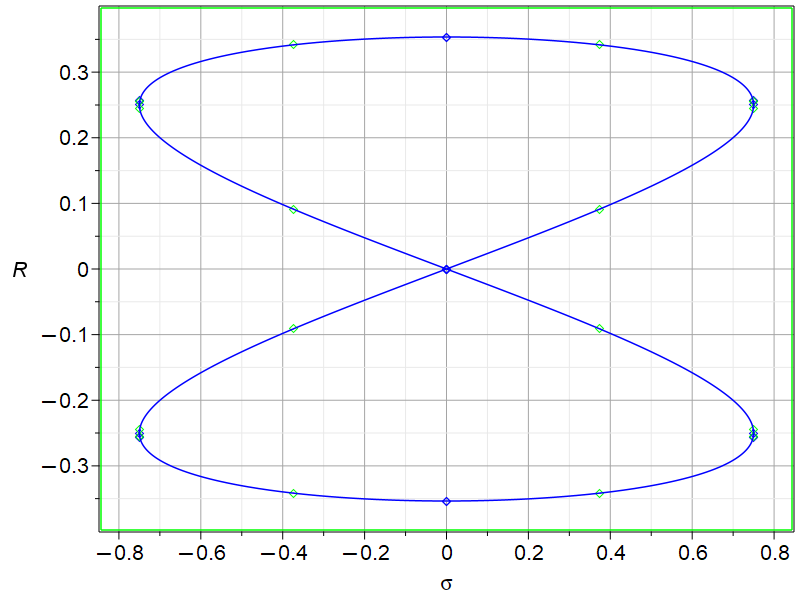

In [54]:
algcurves:-plot_real_curve( eval( numer(steadyR), F=sqrt(8)/3), sigma, R, gridlines, labels=[sigma,R])

kilobytes used=49698, alloc=25992, time=9.09

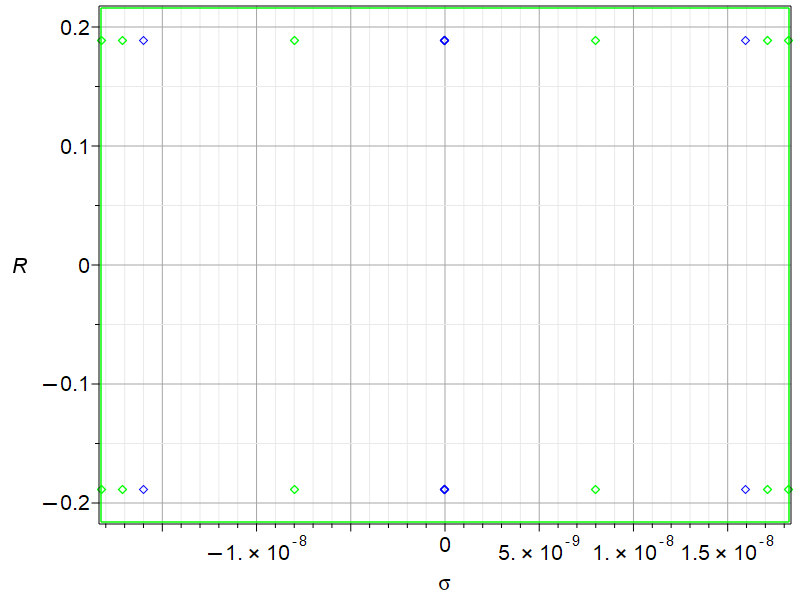

In [55]:
algcurves:-plot_real_curve( eval( numer(steadyR), F=8/sqrt(63)), sigma, R, gridlines, labels=[sigma,R])

In [56]:
verticalSlope := diff( SigmaSquared, R); # when zero, infinite slope

                verticalSlope := - 243/2 R F  - 576 R  + 144 R

$$-\frac{243}{2} R \,F^{2}-576 R^{3}+144 R$$

In [57]:
factor(numer(verticalSlope));

$$-9 R \left(27 F^{2}+128 R^{2}-32\right)$$

In [58]:
inflection := diff( verticalSlope, R);

$$-\frac{243 F^{2}}{2}-1728 R^{2}+144$$

In [59]:
facs := factors( numer( resultant( verticalSlope, inflection, F ) ) );
lprint(facs);

[19591041024, [[R, 6]]]

There are no inflection points on the subharmonic response curves.

To decide the stability, the trace must be negative and the determinant positive.

In [60]:
vert := eval( numer(steadyR), sigma=0 );

$$R^{2} \left(729 F^{4}+3888 F^{2} R^{2}+9216 R^{4}-1296 F^{2}-4608 R^{2}+576\right)$$

In [61]:
factor( discrim( vert/R^2, R) );

$$46221064723759104 \left(9 F^{2}-8\right)^{2} F^{4} \left(63 F^{2}-64\right)^{2}$$

In [62]:
Fcross := sqrt(8)/3;
Ftop := 8/sqrt(63);
evalf([Fcross,Ftop]);

                               Ftop := 8/21 7

| | |
|:-:|:-:|
|.942809041582067|1.00790526135794|


kilobytes used=53575, alloc=25992, time=9.84

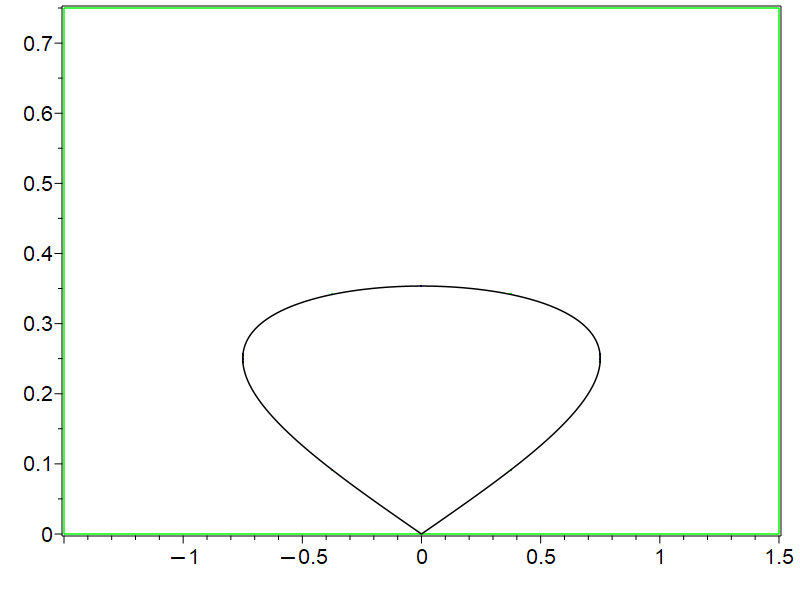

In [63]:
VW := [-1.5..1.5, 0..0.75 ];
crossplot := algcurves:-plot_real_curve( eval( steadyR, F=Fcross), sigma, R,
  view=VW, colorOfCurve=black, symbol=point );

In [64]:
dtcross := algcurves:-plot_real_curve( eval(dt, F=Fcross), sigma, R, 
            view=VW, colorOfCurve="Executive Red",
            symbol=point):
trcross := algcurves:-plot_real_curve( eval(tr, F=Fcross), 
            sigma, R, 
            view=VW, colorOfCurve="Executive Blue",
            symbol=point):

In [65]:
eval(tr, F=Fcross); # always negative

                                   - 8/3 R

$$-\frac{8 R^{2}}{3}$$

In [66]:
eval( dt, F=Fcross ); # Positive if sigma is small

                             4/3 R  - 1/108 sigma

$$\frac{4 R^{4}}{3}-\frac{\sigma^{2}}{108}$$

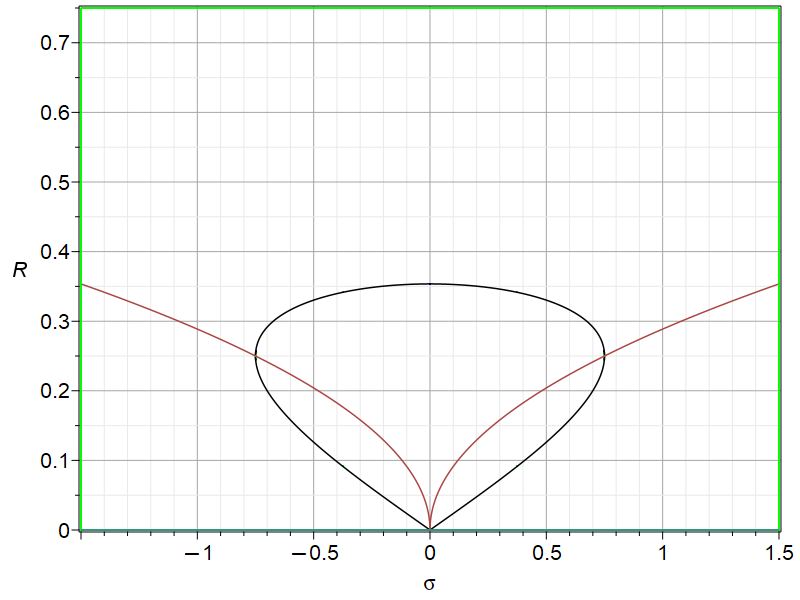

In [67]:
plots[display]( crossplot, dtcross, trcross, gridlines, labels=[sigma,R] );

In [68]:
getR := factors( resultant( vert, diff(vert,R), F )); # multiple roots
lprint( getR );

[99833444963167652693812445184, [[R^2-1/28, 2], [R+1/2, 2], [R-1/2, 2], [R, 20]]]

In [69]:
Rcross := sqrt(1/28);

$$\frac{\sqrt{7}}{14}$$

In [70]:
facs := factors( eval(vert, F=Fcross));
lprint( facs ); # Linear in R; two positive R, two negative R

[9216, [[R, 4], [R^2-1/8, 1]]]

In [71]:
R1 := sqrt(1/8);

$$\frac{\sqrt{2}}{4}$$

In [72]:
collect( eval(steadyR, F=1+u),u,factor);

$$729 R^{2} u^{4}+2916 R^{2} u^{3}+162 R^{2} \left(24 R^{2}+19\right) u^{2}+324 R^{2} \left(24 R^{2}+1\right) u +R^{2} \left(9216 R^{4}-720 R^{2}+64 \sigma^{2}+9\right)$$

kilobytes used=61972, alloc=25992, time=12.44

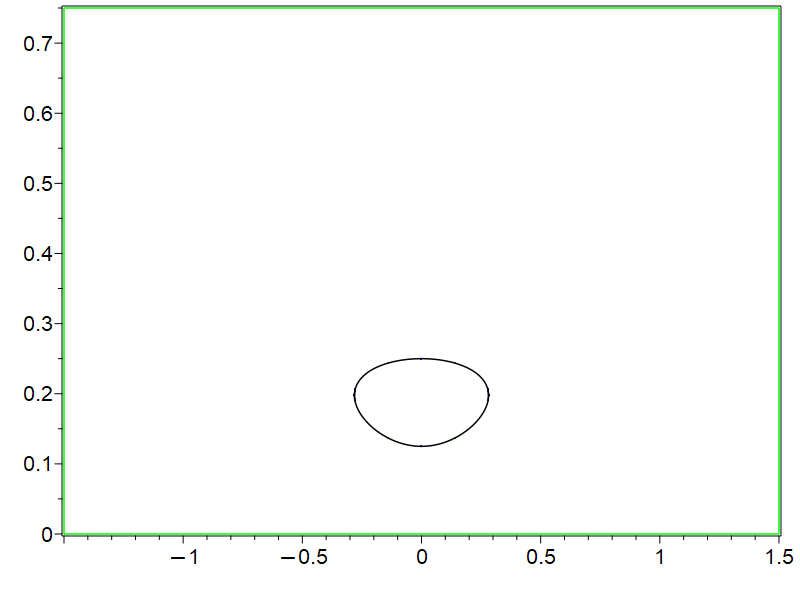

In [73]:
F1plot := algcurves:-plot_real_curve( eval( steadyR, F=1), 
  sigma, R, view=VW, colorOfCurve=black, symbol=point );

In [74]:
map( factor, eval( [dt,tr], F=1 ) ); # Stable for big enough R

              [- 1/768 + 4/3 R  - 1/108 sigma , - 1/24 - 8/3 R ]

| | |
|:-:|:-:|
|-1/768+4/3*R^4-1/108*sigma^2|-1/24-8/3*R^2|


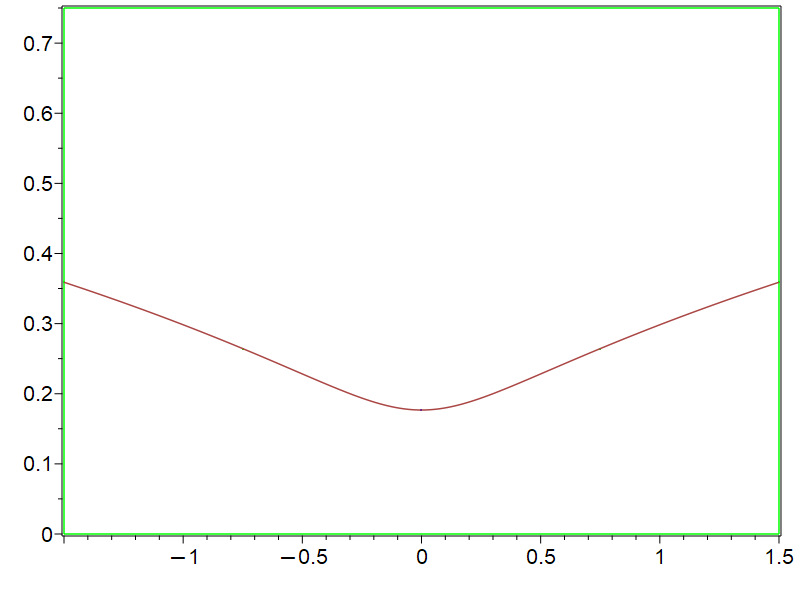

In [75]:
dt1plot := algcurves:-plot_real_curve( eval( dt, F=1), 
  sigma, R, view=VW, colorOfCurve="Executive Red", symbol=point );

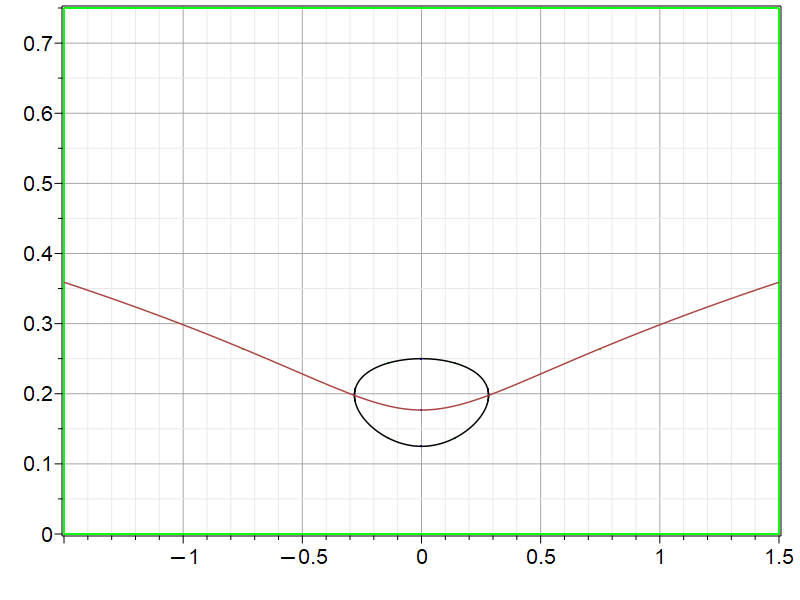

In [76]:
plots[display]( F1plot, dt1plot, gridlines );

In [77]:
factor(eval(tr, F=sqrt(8)/3));

$$-\frac{8 R^{2}}{3}$$

In [78]:
collect( dt, R, factor );

$$-\frac{1}{12}+\frac{3}{16} F^{2}-\frac{27}{256} F^{4}+\frac{4}{3} R^{4}-\frac{1}{108} \sigma^{2}$$

In [79]:
evalf( simplify( eval([dt,tr], [F=Fcross, R=R1]) ) ); # stable small sigma

     [0.0208333333333333 - 0.00925925925925926 sigma , -0.333333333333333]

| | |
|:-:|:-:|
|.208333333333333e-1-.925925925925926e-2*sigma^2|-.333333333333333|


In [80]:
plot34 := algcurves:-plot_real_curve( eval(steadyR, F=3/4), 
sigma, R , view=VW, colorOfCurve=black, symbol=point):

kilobytes used=67624, alloc=25992, time=13.89

In [81]:
dt34plot := algcurves:-plot_real_curve( eval(dt, F=3/4), sigma, R, 
  view=VW, colorOfCurve="Executive Red", symbol=point):

In [82]:
eval(expand(R*tr), F=3/4);

$$\frac{47}{384} R -\frac{8}{3} R^{3}$$

In [83]:
tr34plot := algcurves:-plot_real_curve( eval(tr, F=3/4), sigma, R, 
view=VW, colorOfCurve="Executive Blue", symbol=point):

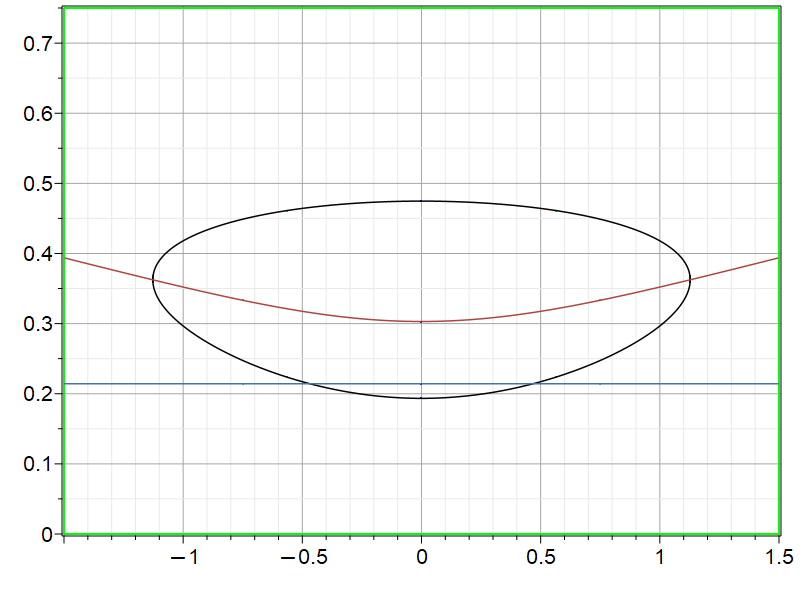

In [84]:
plots[display](plot34, dt34plot, tr34plot, gridlines );

In [85]:
ncurves := 8;
flist := [seq(k/ncurves,k=1..ncurves-2), Fcross, 8/sqrt(63)]; # slices of F
steadyplots := Array(1..ncurves);
dtplots := Array(1..ncurves);
trplots := Array(1..ncurves);
slices := Array(1..ncurves);
for k to ncurves do
  steadyplots[k] := algcurves:-plot_real_curve( eval(steadyR, F=flist[k]), 
sigma, R , view=VW, colorOfCurve=black, symbol=point);
  dtplots[k] := algcurves:-plot_real_curve( eval(dt, F=flist[k]), sigma, R, 
  view=VW, colorOfCurve="Executive Red", symbol=point);
  trplots[k] := algcurves:-plot_real_curve( eval(tr, F=flist[k]), sigma, R, 
view=VW, colorOfCurve="Executive Blue", symbol=point);
  slices[k] := plots[display]( steadyplots[k], dtplots[k], trplots[k]);
end do:

kilobytes used=115646, alloc=27016, time=26.03

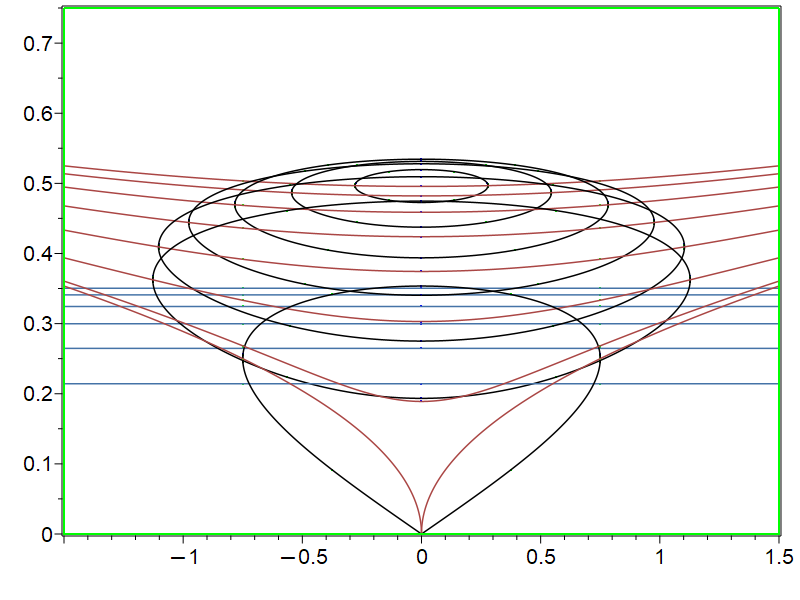

In [86]:
plots[display]( seq( slices[k], k=1..ncurves));

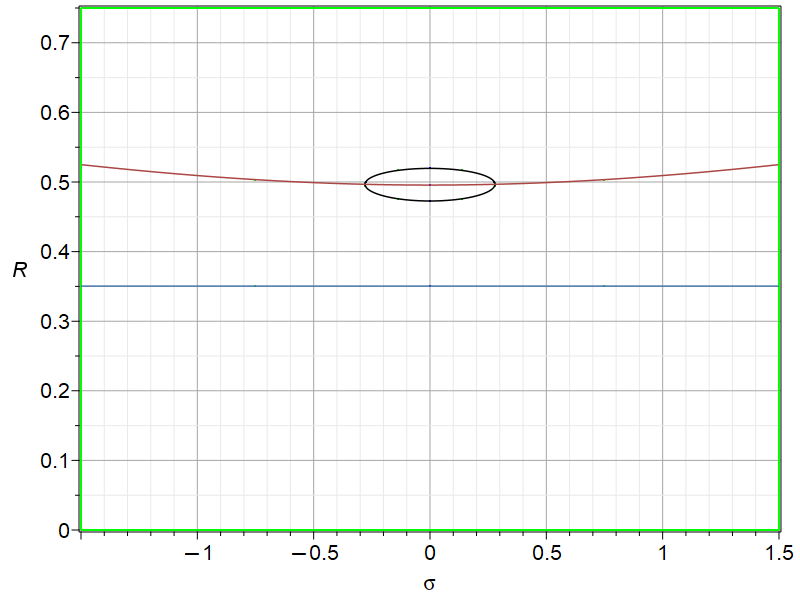

In [87]:
plots[display]( slices[1], gridlines, labels=[sigma,R]); # 

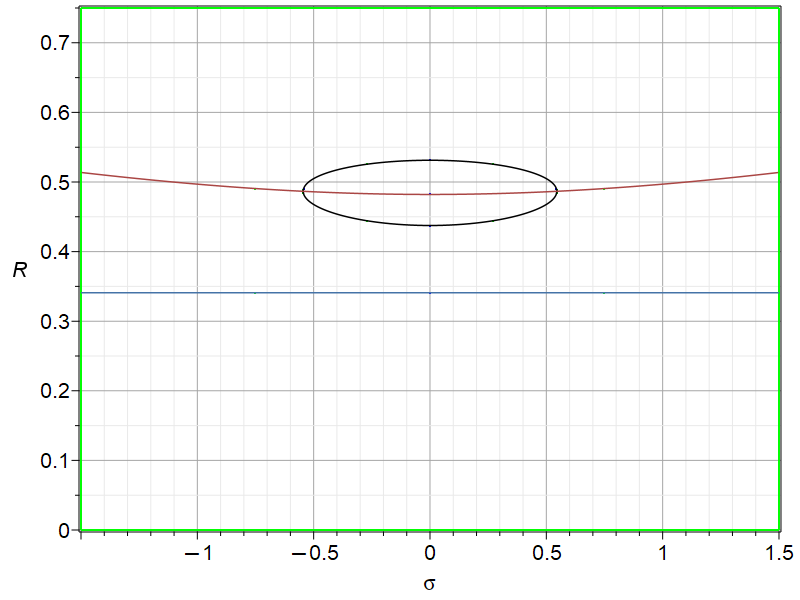

In [88]:
plots[display]( slices[2], gridlines, labels=[sigma,R]); # 

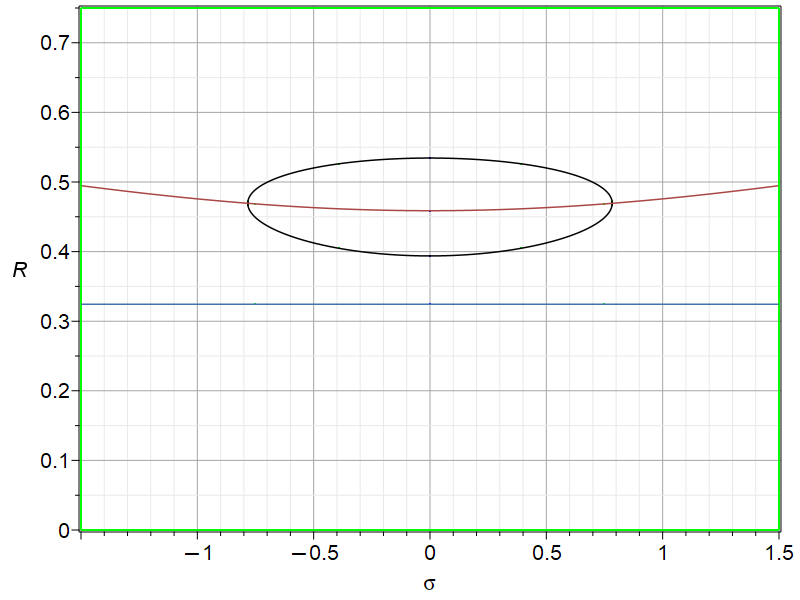

In [89]:
plots[display]( slices[3], gridlines, labels=[sigma,R]); # 

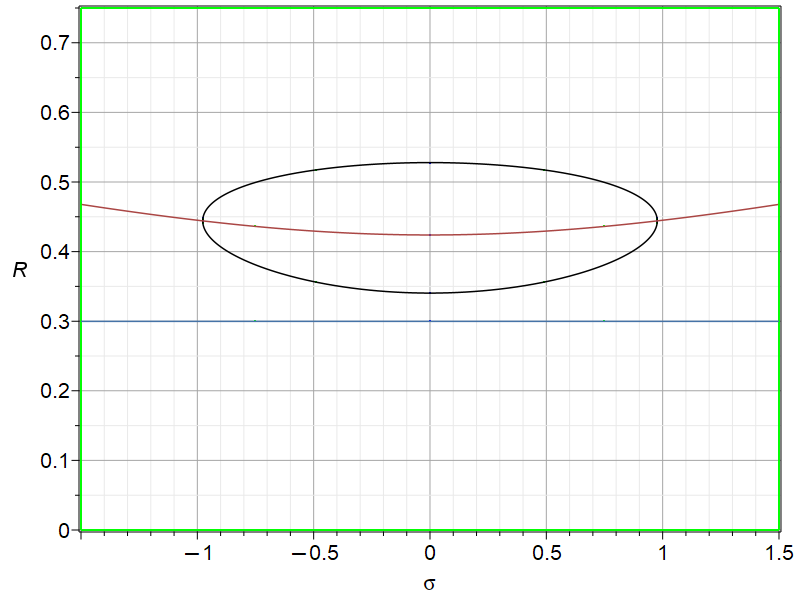

In [90]:
plots[display]( slices[4], gridlines, labels=[sigma,R]); # 

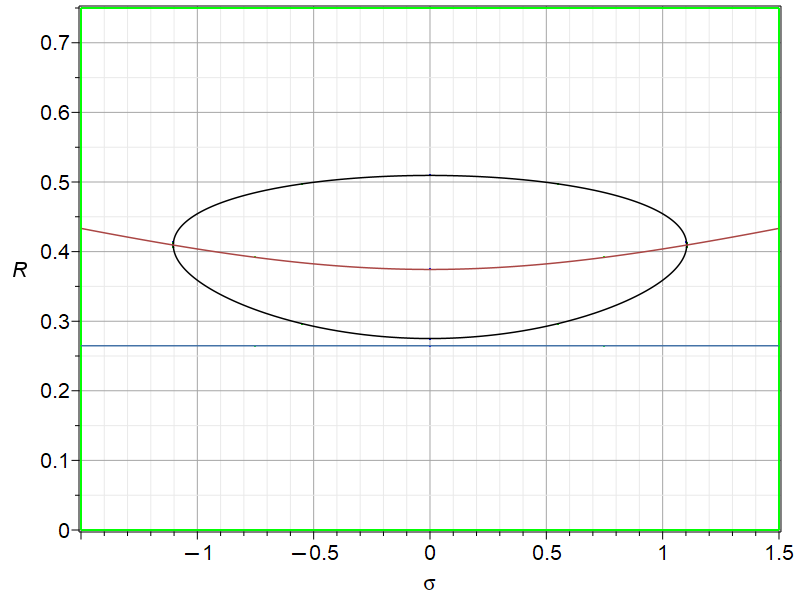

In [91]:
plots[display]( slices[5], gridlines, labels=[sigma,R]); # 

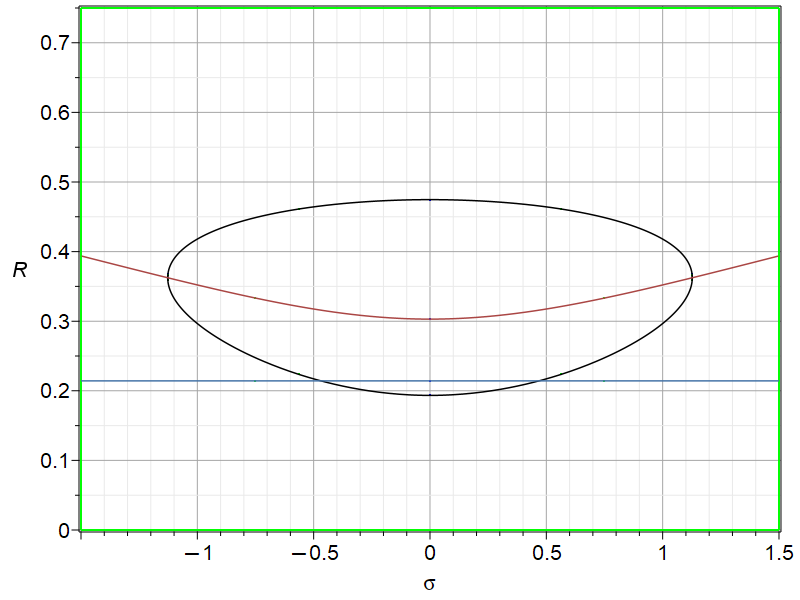

In [92]:
plots[display]( slices[6], gridlines, labels=[sigma,R]); # 

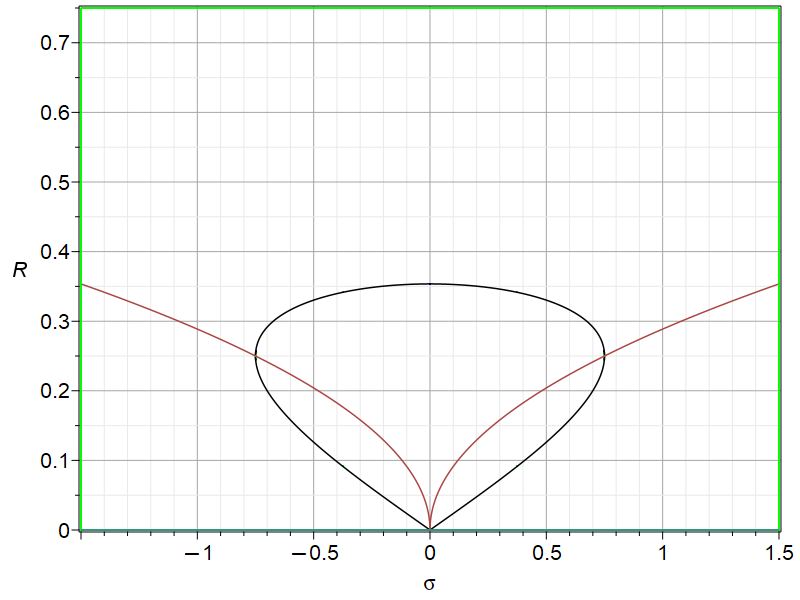

In [93]:
plots[display]( slices[7], gridlines, labels=[sigma,R]); # 

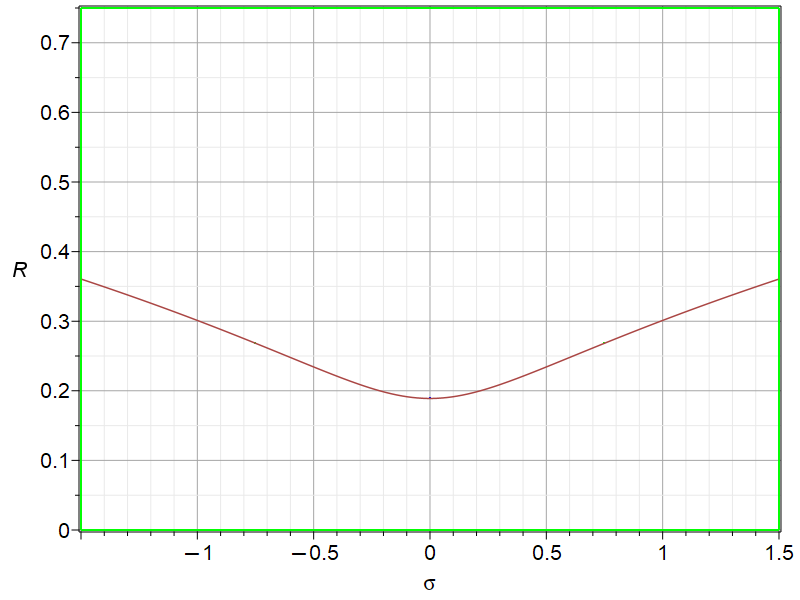

In [94]:
plots[display]( slices[8], gridlines, labels=[sigma,R]); # 

kilobytes used=129687, alloc=27016, time=29.33

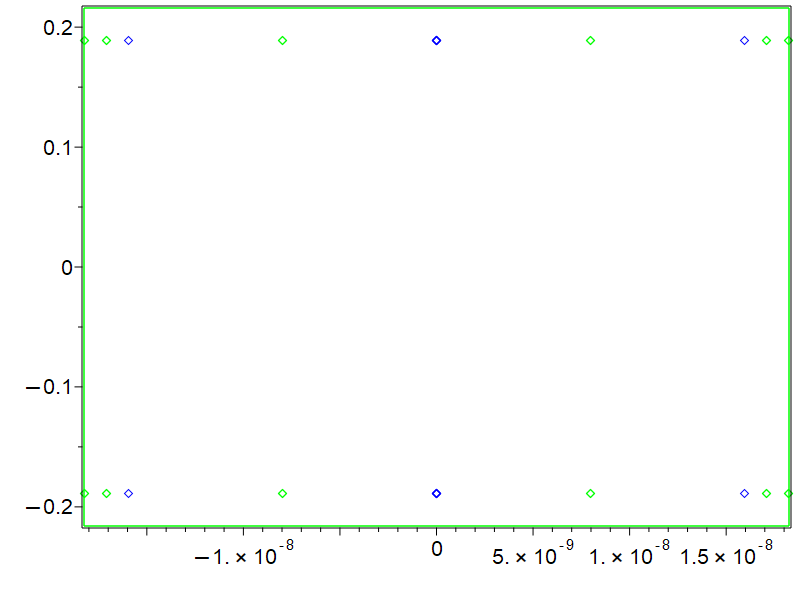

In [95]:
algcurves:-plot_real_curve( eval(steadyR, F=8/sqrt(63)), sigma, R );

In [96]:
ncurves := 12;
flist := [seq( Fcross + k*(8/sqrt(63)-Fcross)/ncurves, k=1..ncurves)]; # slices of F
steadyplots := Array(1..ncurves);
dtplots := Array(1..ncurves);
trplots := Array(1..ncurves);
thinslices := Array(1..ncurves);
for k to ncurves do
  steadyplots[k] := algcurves:-plot_real_curve( eval(steadyR, F=flist[k]), 
sigma, R , view=VW, colorOfCurve=black, symbol=point);
  dtplots[k] := algcurves:-plot_real_curve( eval(dt, F=flist[k]), sigma, R, 
  view=VW, colorOfCurve="Executive Red", symbol=point);
  trplots[k] := algcurves:-plot_real_curve( eval(expand(R*tr), F=flist[k]), sigma, R, 
view=VW, colorOfCurve="Executive Blue", symbol=point);
  thinslices[k] := plots[display]( steadyplots[k], dtplots[k], trplots[k]);
end do:

Warning, cannot evaluate the solution past the initial point, problem may be complex, initially singular or improperly set up

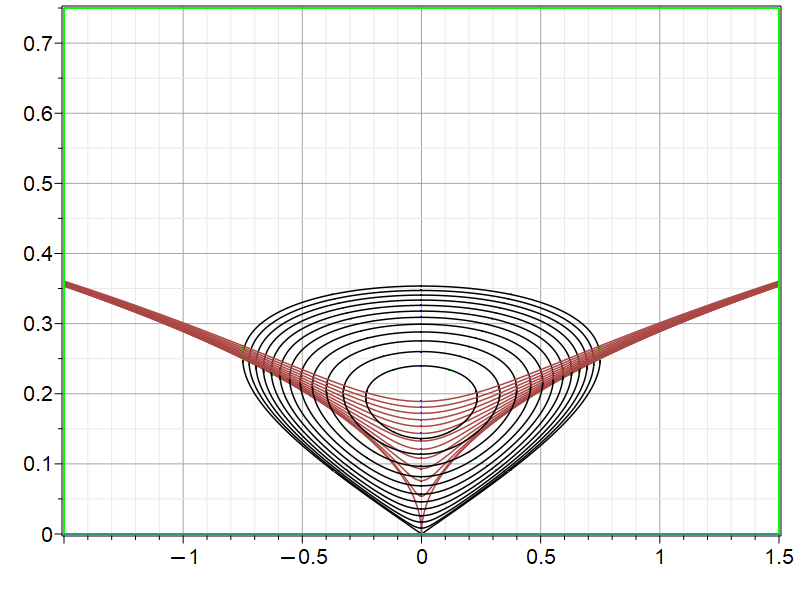

In [97]:
plots[display]( slices[7], seq(thinslices[k],k=1..ncurves), gridlines);

In [98]:
ok := isolate( resultant( steadyR, dt, F ), sigma^2 );

$$\sigma^{2} = -112 R^{4}+32 R^{2}-1$$

In [99]:
factor( eval(steadyR, ok ) );

$$R^{2} \left(27 F^{2}+128 R^{2}-32\right) \left(27 F^{2}+16 R^{2}-16\right)$$

In [100]:
FF1 := sqrt( 16*(1-R^2)/27);
FF2 := sqrt( 32*(1-4*R^2)/27 );

                           FF1 := 4/9 (-3 R  + 3)

$$\frac{4 \sqrt{-24 R^{2}+6}}{9}$$

In [101]:
factor(eval(steadyR,F=FF1));

$$64 R^{2} \left(112 R^{4}-32 R^{2}+\sigma^{2}+1\right)$$

In [102]:
maybe := factor(eval(steadyR,F=FF2));

$$64 R^{2} \left(112 R^{4}-32 R^{2}+\sigma^{2}+1\right)$$

In [103]:
factor( resultant( maybe, eval(dt, F=FF1), sigma));

$$\frac{4096 R^{8} \left(7 R^{2}-1\right)^{2}}{9}$$

In [104]:
factor( resultant( SigmaSquared, diff(SigmaSquared,R), R ));

$$-\frac{387420489 \left(9 F^{2}-8\right)^{2} F^{4} \left(63 F^{2}-64\right)^{2}}{4}$$

In [105]:
isolate( factor( resultant( steadyR, dt, sigma) )/R^8, R^2);

$$R^{2} = -\frac{27 F^{2}}{128}+\frac{1}{4}$$

In [106]:
facs := factors( eval( steadyR, sigma=0 )/R^2/9 );

| | |
|:-:|:-:|
|81|[[F^2-4/3*F*R+32/9*R^2-8/9, 1], [F^2+4/3*F*R+32/9*R^2-8/9, 1]]|


In [107]:
roots1 := solve( facs[2][1][1], R );

$$\frac{3 F}{16}+\frac{\sqrt{-63 F^{2}+64}}{16}$$,$$\frac{3 F}{16}-\frac{\sqrt{-63 F^{2}+64}}{16}$$

In [108]:
roots2 := solve( facs[2][2][1], R )

$$-\frac{3 F}{16}+\frac{\sqrt{-63 F^{2}+64}}{16}$$,$$-\frac{3 F}{16}-\frac{\sqrt{-63 F^{2}+64}}{16}$$

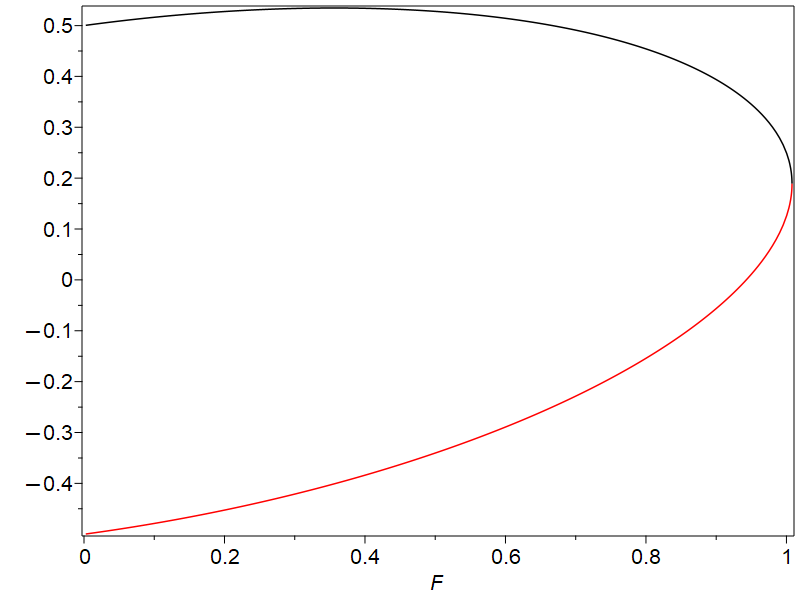

In [109]:
plot( [roots1], F=0..8/sqrt(63), color=[black,red] );

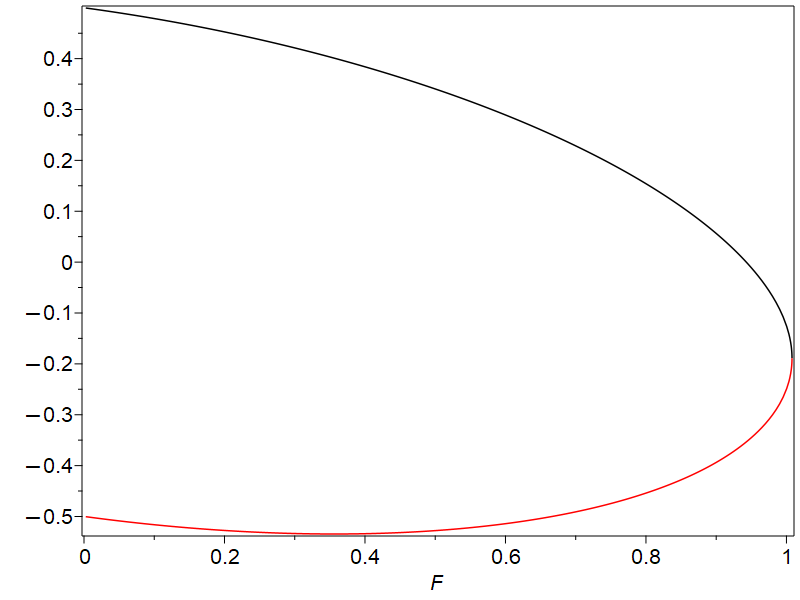

In [110]:
plot( [roots2], F=0..8/sqrt(63), color=[black,red] );

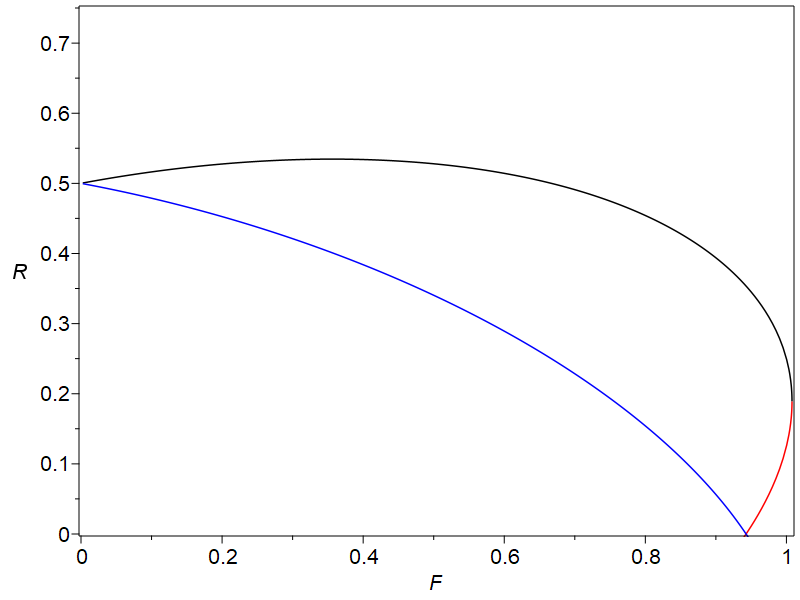

In [111]:
plot( [roots1,roots2], F=0..8/sqrt(63), colour=[black,red,blue,green], 
view=[0..8/sqrt(63),0..0.75], labels=[F,R]);

In [112]:
solve( roots1[1], F);

$$-\frac{2 \sqrt{2}}{3}$$

In [113]:
evalf(sqrt(8)/3)

$$ 0.942809041582067$$

In [114]:
lprint( roots1[1] );

3/16*F+1/16*(-63*F^2+64)^(1/2)

In [115]:
big := 3/16*F+1/16*(-63*F^2+64)^(1/2);

$$\frac{3 F}{16}+\frac{\sqrt{-63 F^{2}+64}}{16}$$

In [116]:
small1 := 3/16*F-1/16*(-63*F^2+64)^(1/2);

$$\frac{3 F}{16}-\frac{\sqrt{-63 F^{2}+64}}{16}$$

In [117]:
small2 := -3/16*F+1/16*(-63*F^2+64)^(1/2)

$$-\frac{3 F}{16}+\frac{\sqrt{-63 F^{2}+64}}{16}$$

In [118]:
ncurves1 := 12;
phi := evalf( (1+sqrt(5))/2);
flist1 := [seq( sqrt(8)/3 + k*(-sqrt(8)/3+8/sqrt(63))/ncurves1, 
               k=0..ncurves1-3), 0.995*8/sqrt(63),0.9995*8/sqrt(63)];
ncurves2 := 24;
flist2 := [seq(  k*(sqrt(8)/3)/ncurves2, k=1..ncurves2)];
plotcurves1 := Array(1..ncurves1);
plotcurves2 := Array(1..ncurves2);
for k to ncurves1 do
  plotcurves1[k] := plot( eval( [[-sqrt(SigmaSquared), R, R=sqrt(1/4-27*F^2/128)..big],
                                 [ sqrt(SigmaSquared), R, R=sqrt(1/4-27*F^2/128)..big]],
                                 F=flist1[k])
                        );
end do:
for k to ncurves2 do
  plotcurves2[k] := plot( eval( [[-sqrt(SigmaSquared), R, R=sqrt(1/4-27*F^2/128)..big],
                                 [ sqrt(SigmaSquared), R, R=sqrt(1/4-27*F^2/128)..big]],
                                 F=flist2[k])
                        );
end do:

        ]

In [119]:
seq( evalf[3]( flist1[k]), k=1..ncurves1);

$$ 0.940$$,$$ 0.946$$,$$ 0.952$$,$$ 0.957$$,$$ 0.963$$,$$ 0.969$$,$$ 0.974$$,$$ 0.980$$,$$ 0.986$$,$$ 0.993$$,$$ 1.0$$,$$ 1.01$$

kilobytes used=274585, alloc=33246, time=54.38

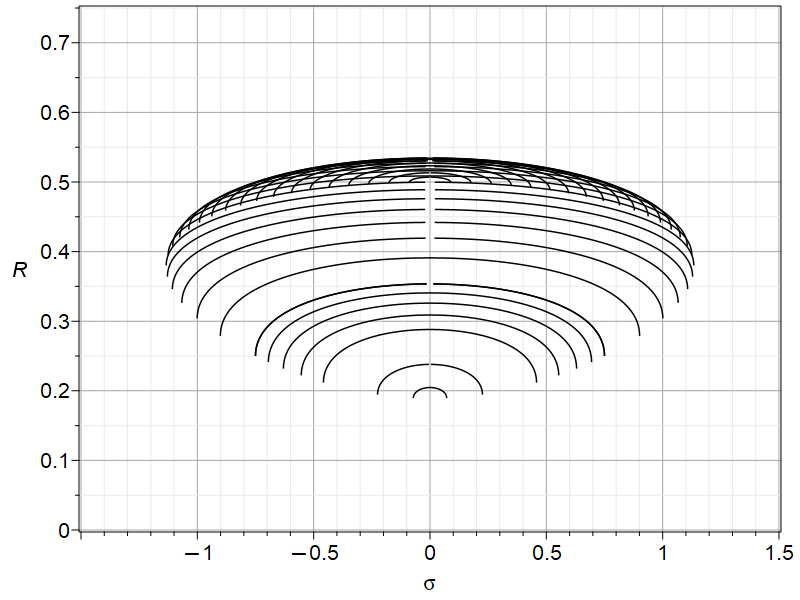

In [120]:
plots[display]( seq(plotcurves1[k],k=[1,3,5,7,9,11,12]),
                seq(plotcurves2[k],k=1..ncurves2), view=VW, 
                gridlines, labels=[sigma,R]);

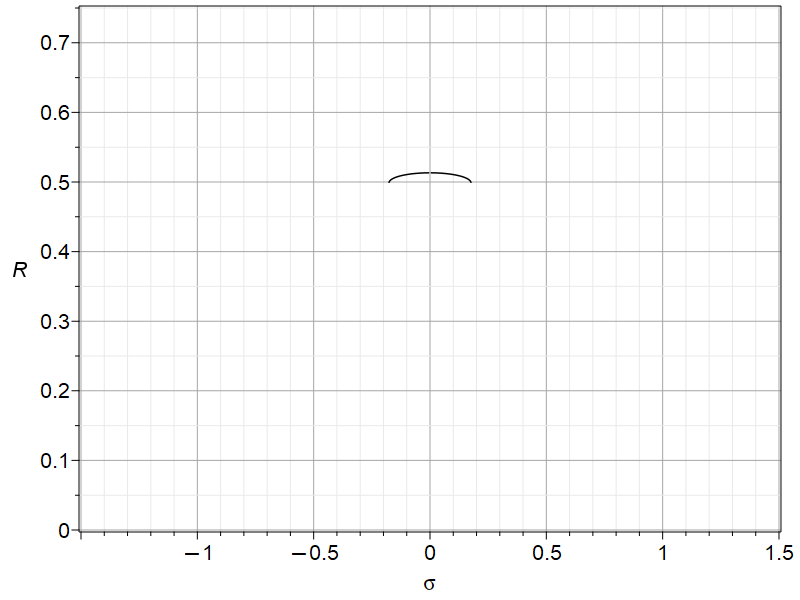

In [121]:
plots[display]( plotcurves2[2], view=VW, 
                gridlines, labels=[sigma,R]);

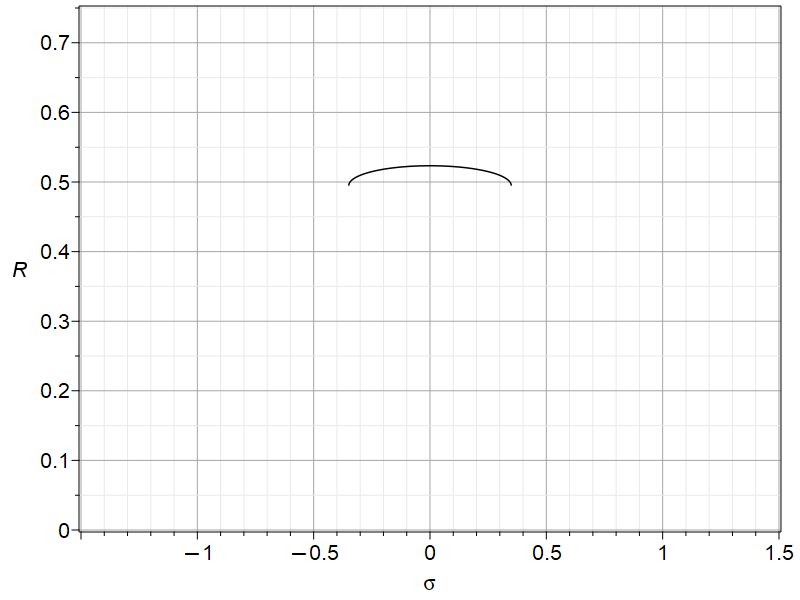

In [122]:
plots[display]( plotcurves2[4], view=VW, 
                gridlines, labels=[sigma,R]);

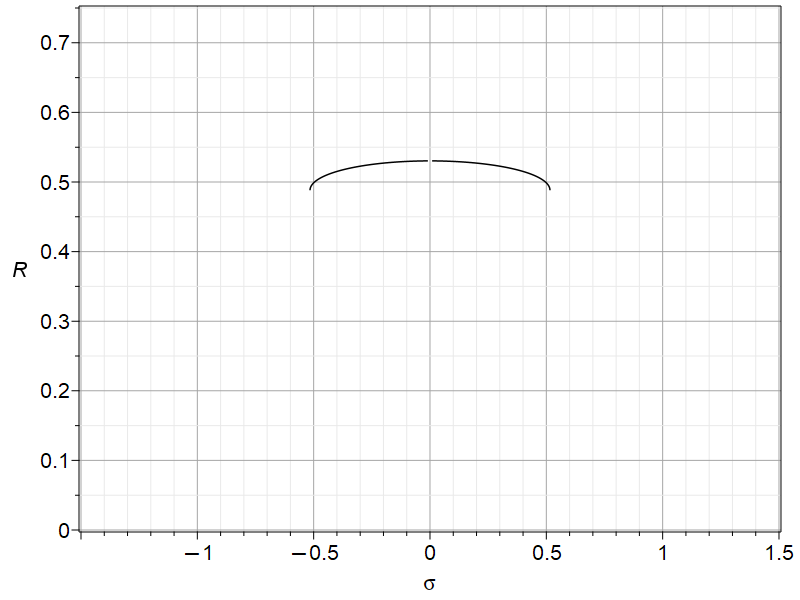

In [123]:
plots[display]( plotcurves2[6], view=VW, 
                gridlines, labels=[sigma,R]);

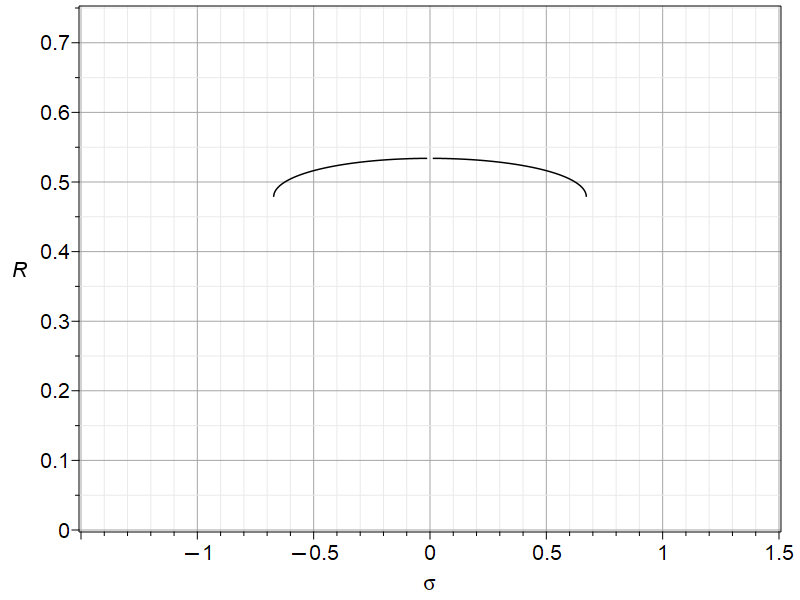

In [124]:
plots[display]( plotcurves2[8], view=VW, 
                gridlines, labels=[sigma,R]);

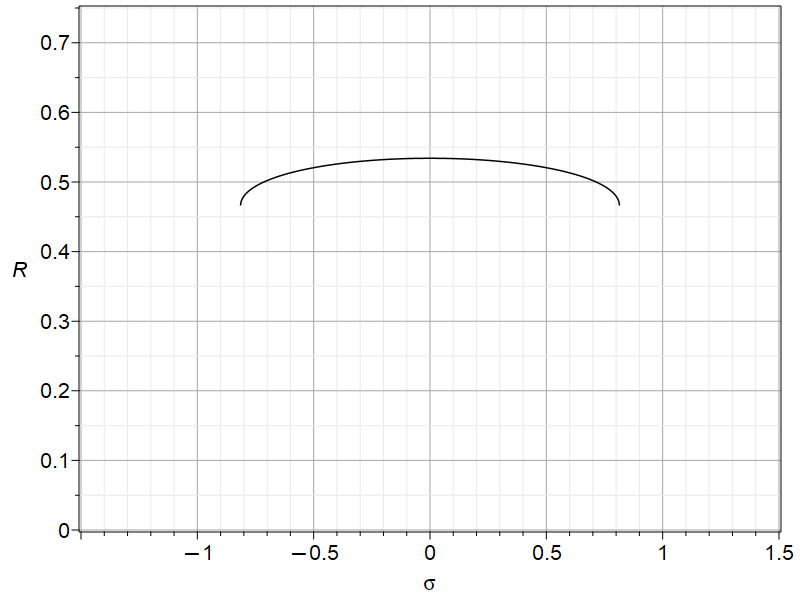

In [125]:
plots[display]( plotcurves2[10], view=VW, 
                gridlines, labels=[sigma,R]);

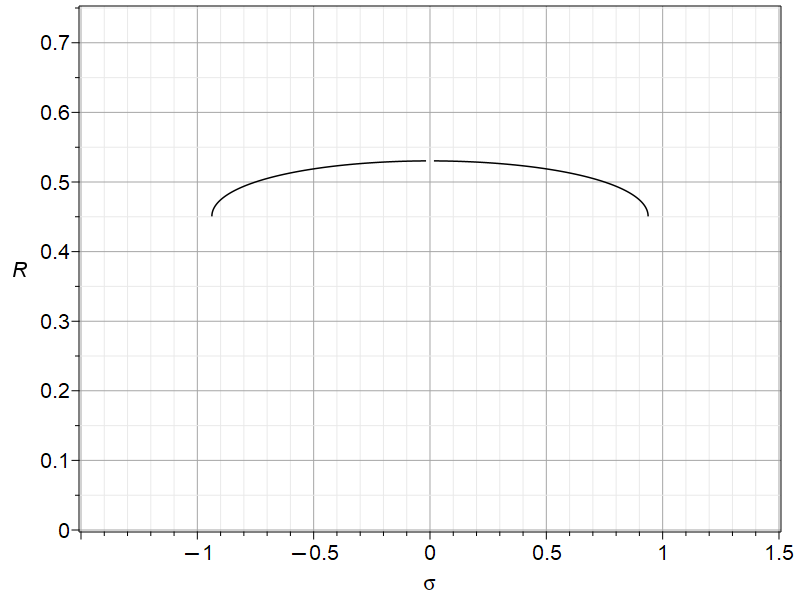

In [126]:
plots[display]( plotcurves2[12], view=VW, 
                gridlines, labels=[sigma,R]);

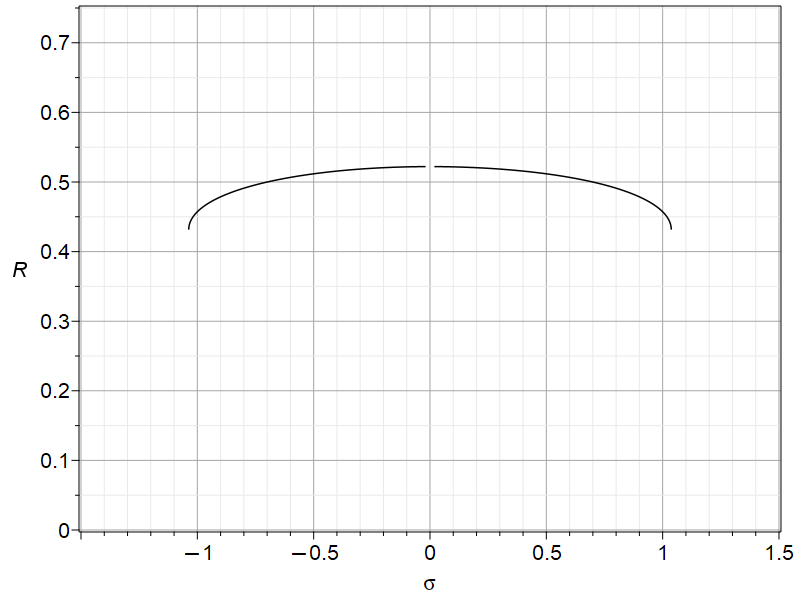

In [127]:
plots[display]( plotcurves2[14], view=VW, 
                gridlines, labels=[sigma,R]);

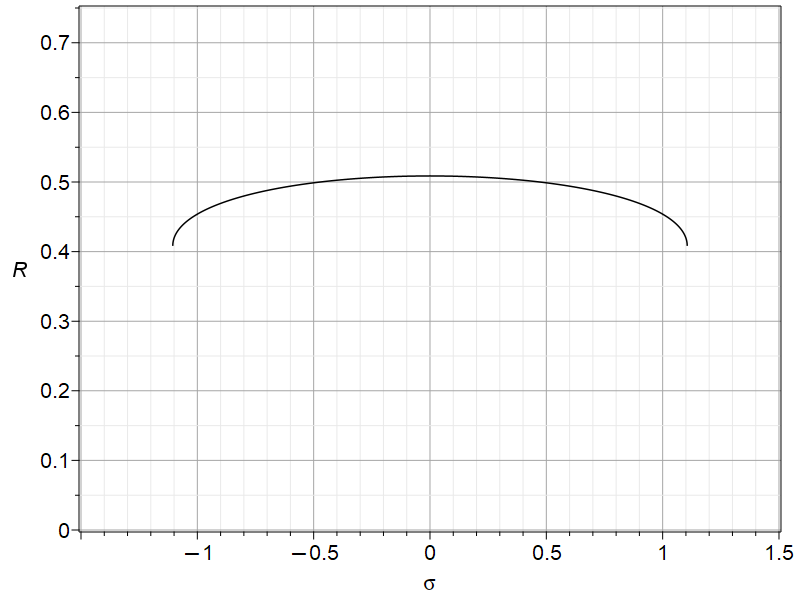

In [128]:
plots[display]( plotcurves2[16], view=VW, 
                gridlines, labels=[sigma,R]);

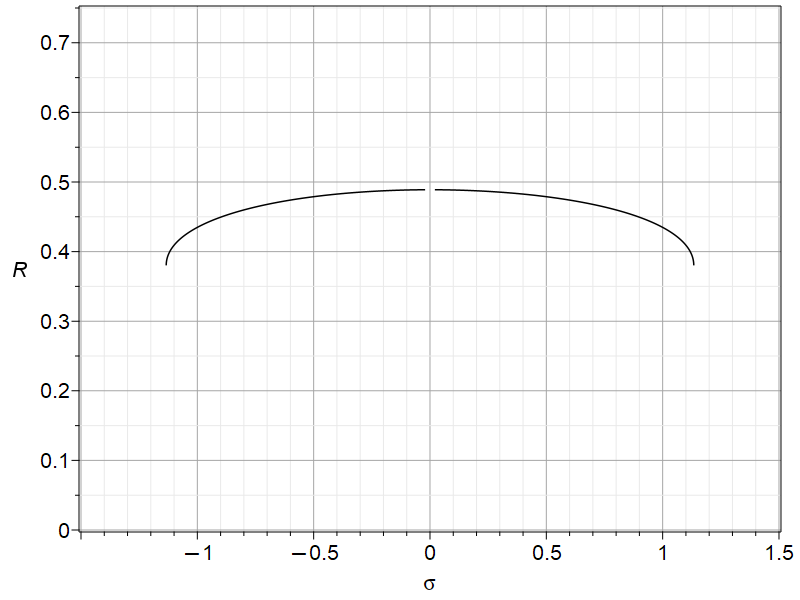

In [129]:
plots[display]( plotcurves2[18], view=VW, 
                gridlines, labels=[sigma,R]);

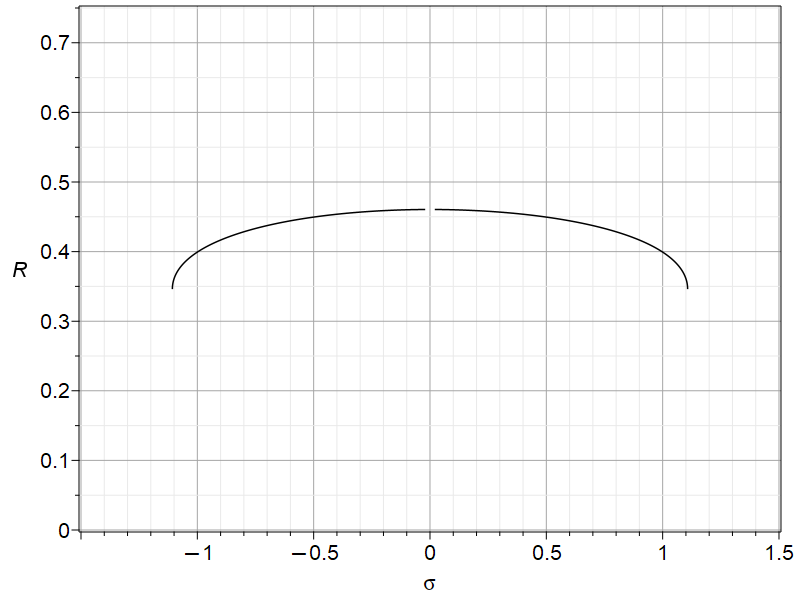

In [130]:
plots[display]( plotcurves2[20], view=VW, 
                gridlines, labels=[sigma,R]);

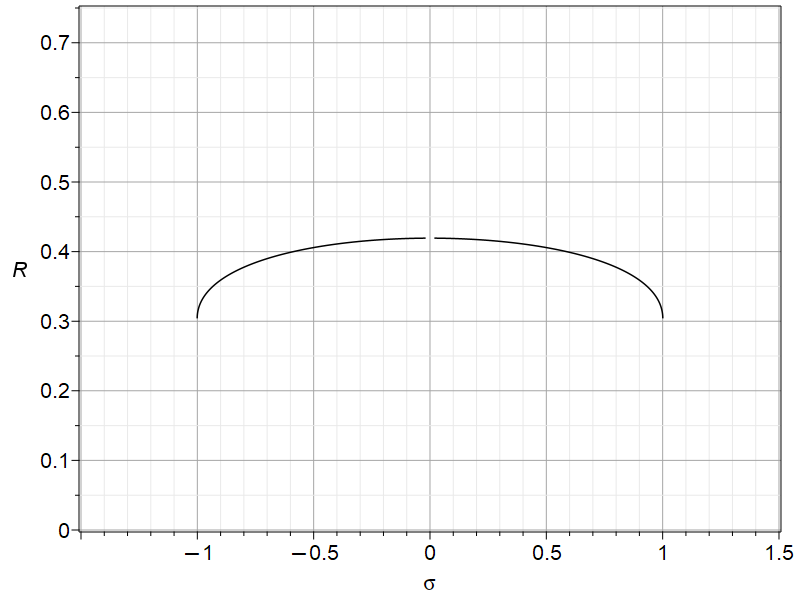

In [131]:
plots[display]( plotcurves2[22], view=VW, 
                gridlines, labels=[sigma,R]);

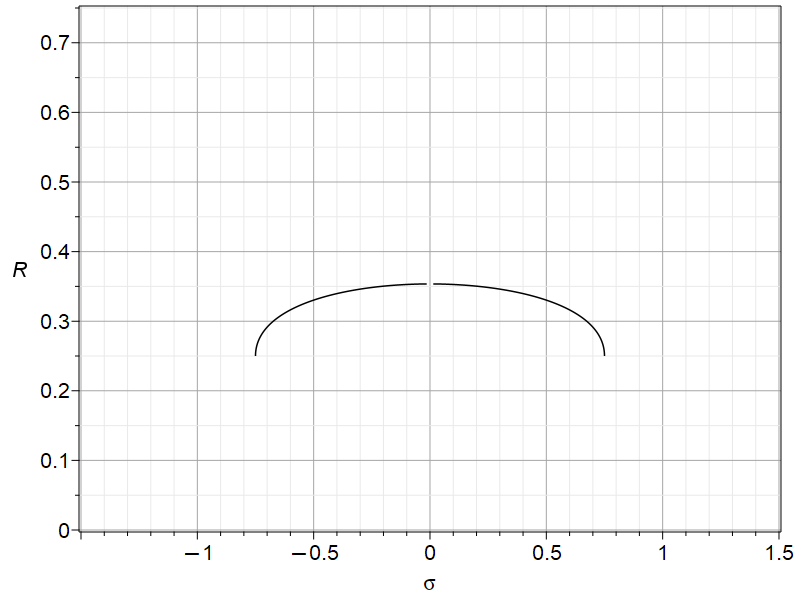

In [132]:
plots[display]( plotcurves2[24], view=VW, 
                gridlines, labels=[sigma,R]);

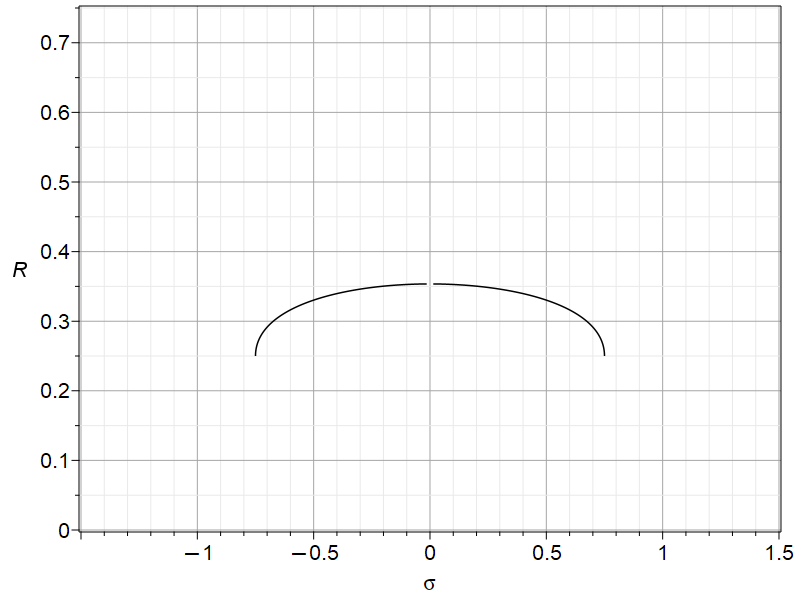

In [133]:
plots[display]( plotcurves1[1], view=VW, 
                gridlines, labels=[sigma,R]);

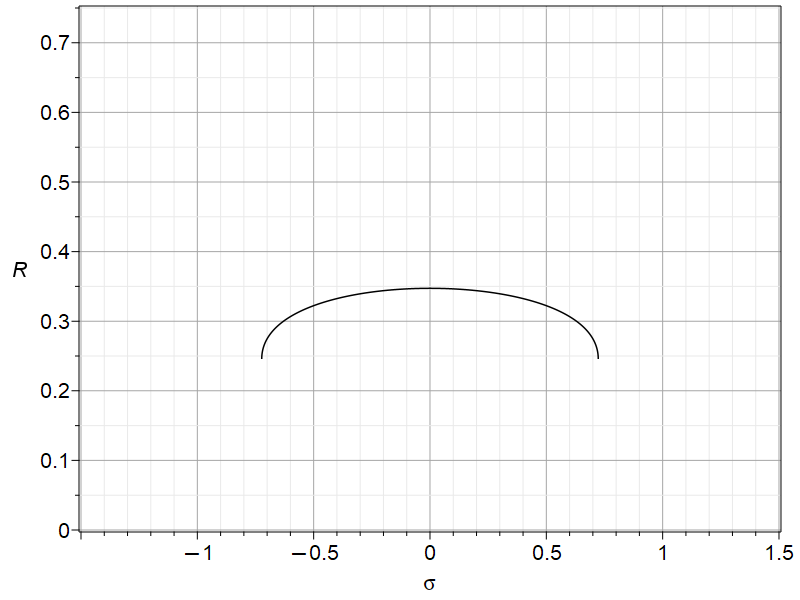

In [134]:
plots[display]( plotcurves1[2], view=VW, 
                gridlines, labels=[sigma,R]);

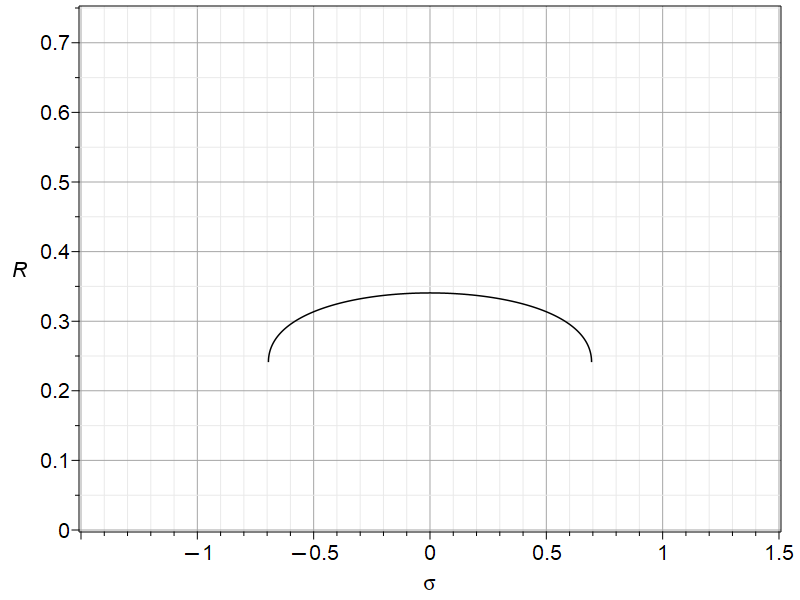

In [135]:
plots[display]( plotcurves1[3], view=VW, 
                gridlines, labels=[sigma,R]);

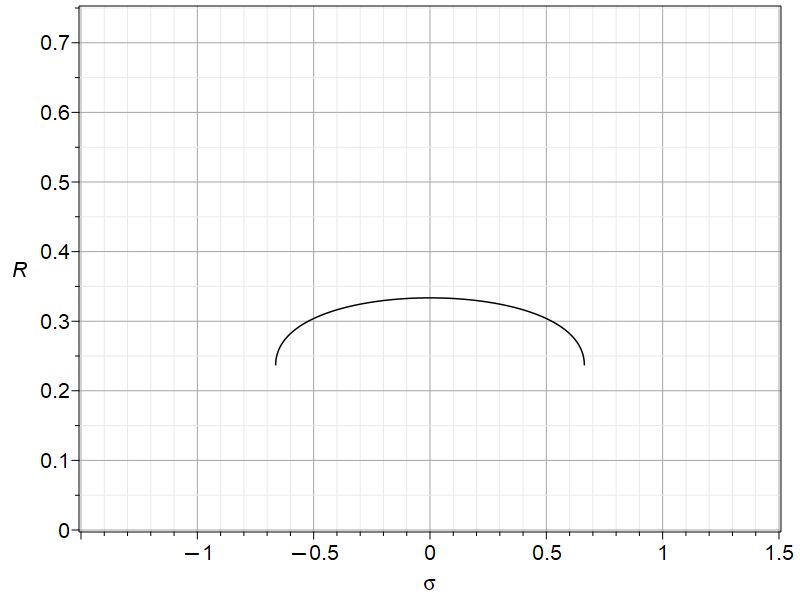

In [136]:
plots[display]( plotcurves1[4], view=VW, 
                gridlines, labels=[sigma,R]);

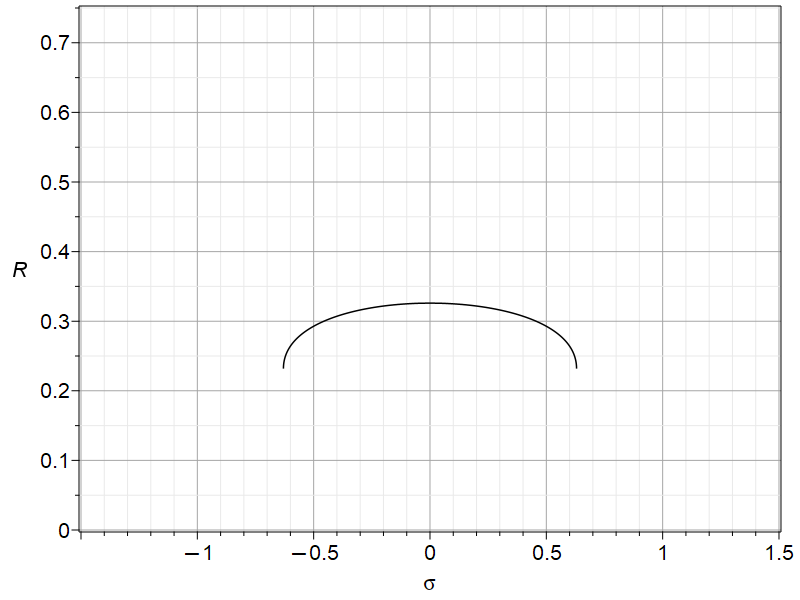

In [137]:
plots[display]( plotcurves1[5], view=VW, 
                gridlines, labels=[sigma,R]);

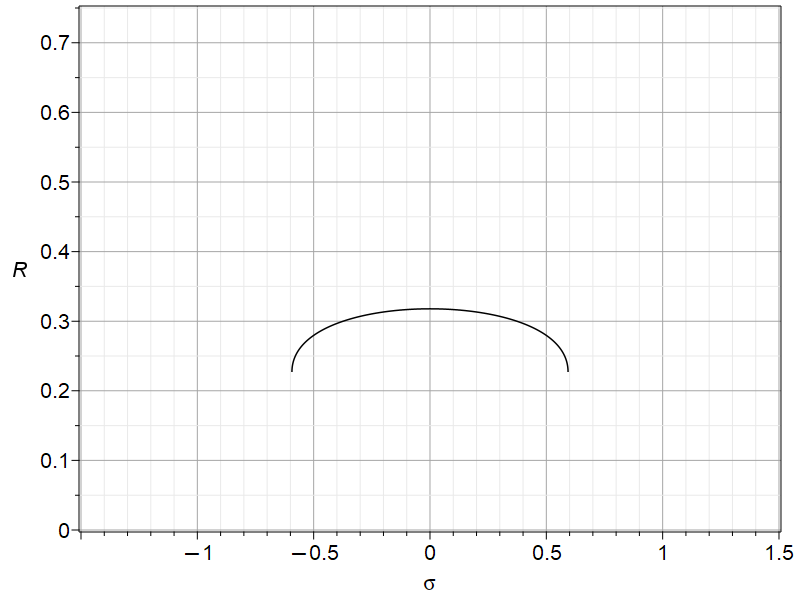

In [138]:
plots[display]( plotcurves1[6], view=VW, 
                gridlines, labels=[sigma,R]);

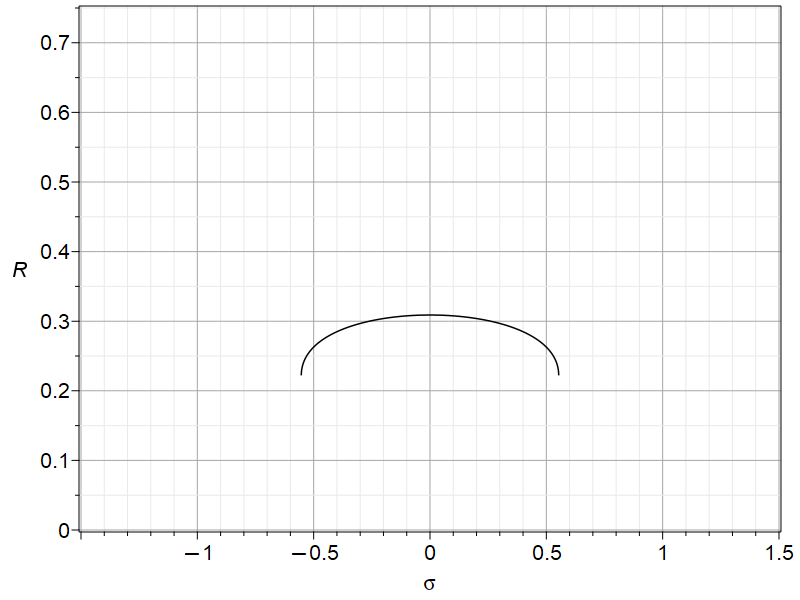

In [139]:
plots[display]( plotcurves1[7], view=VW, 
                gridlines, labels=[sigma,R]);

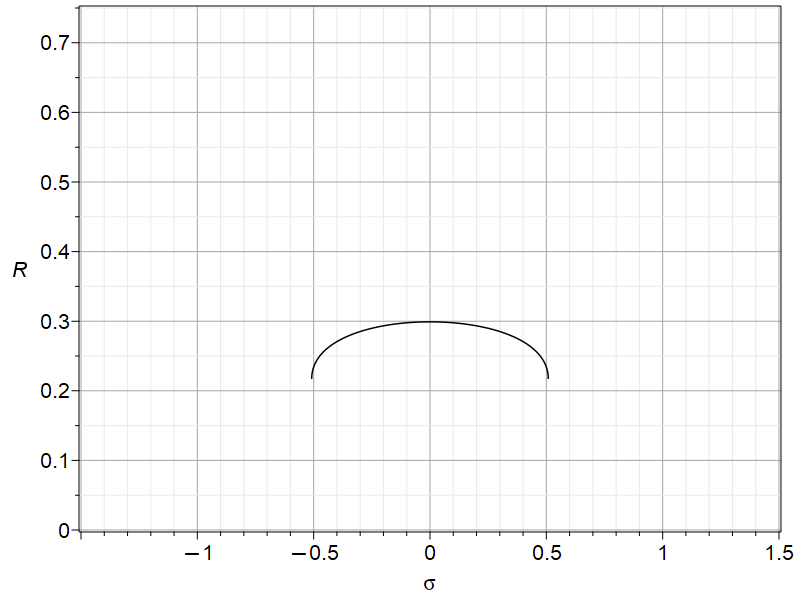

In [140]:
plots[display]( plotcurves1[8], view=VW, 
                gridlines, labels=[sigma,R]);

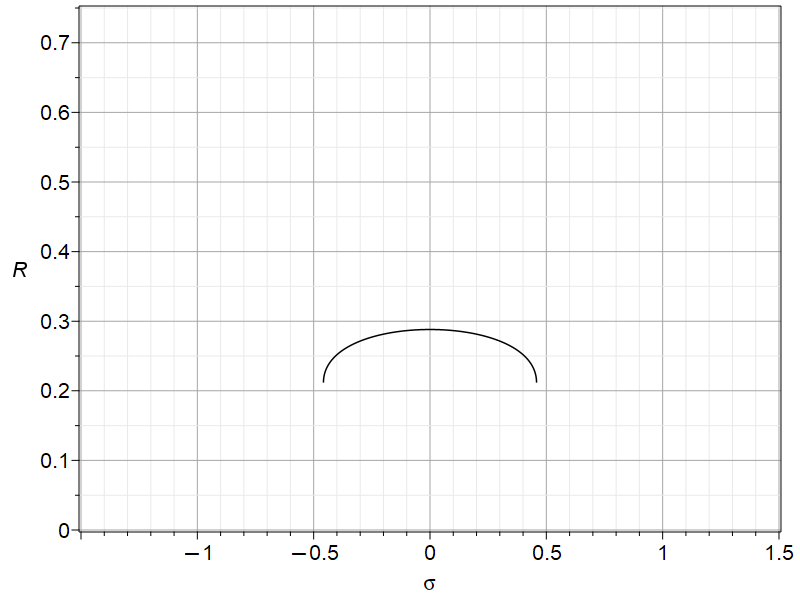

In [141]:
plots[display]( plotcurves1[9], view=VW, 
                gridlines, labels=[sigma,R]);

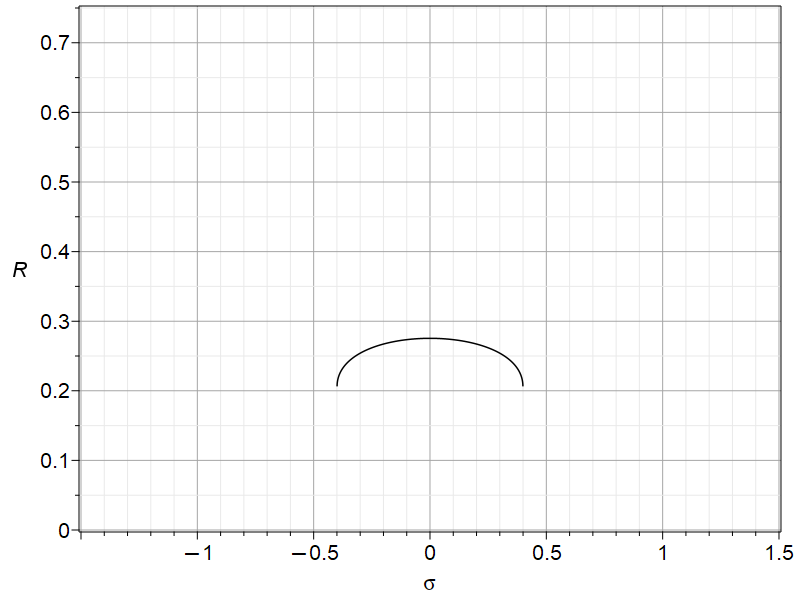

In [142]:
plots[display]( plotcurves1[10], view=VW, 
                gridlines, labels=[sigma,R]);

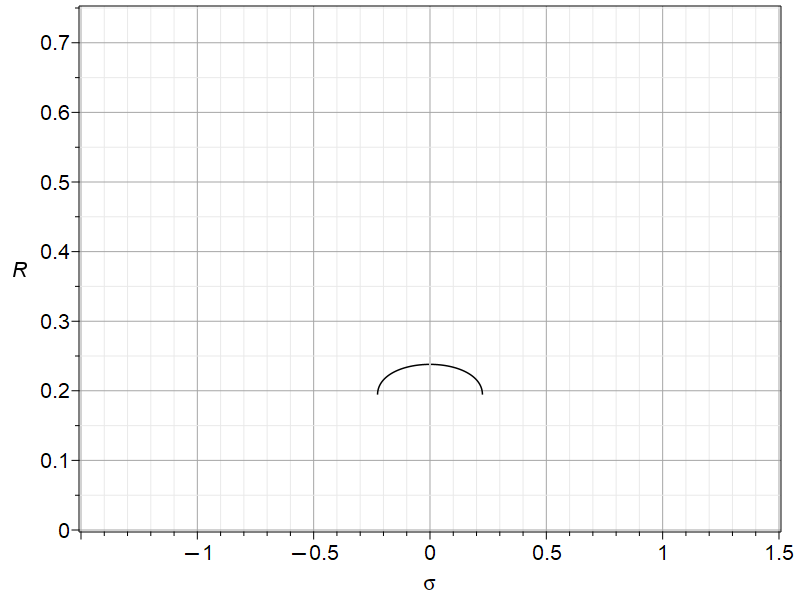

In [143]:
plots[display]( plotcurves1[11], view=VW, 
                gridlines, labels=[sigma,R]);

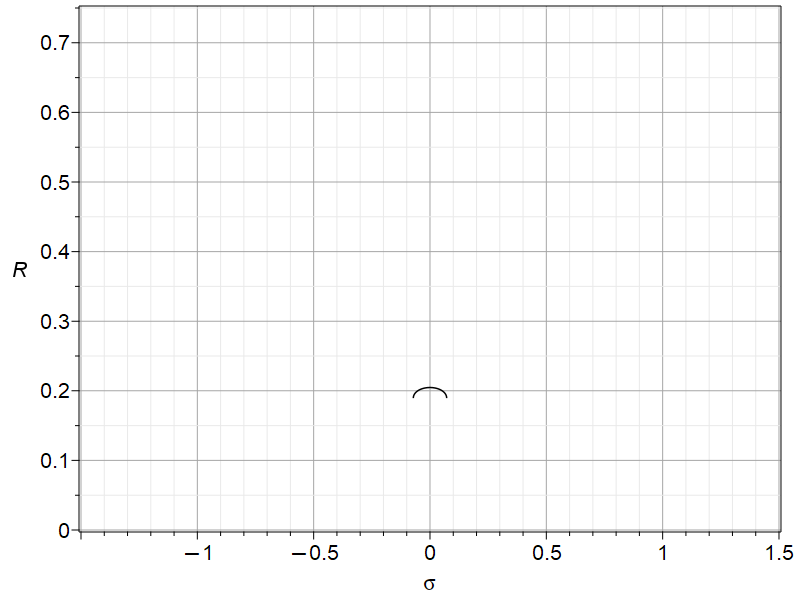

In [144]:
plots[display]( plotcurves1[12], view=VW, 
                gridlines, labels=[sigma,R]);

In [145]:
de1 := diff(g(t),t) = expand(eval( diff(R(tau),tau)/ep,
  [R(tau)=g(t), theta(tau)=psi(t)] ));

$$\frac{d}{d t}g \left(t \right) = \frac{g \left(t \right)}{6}-\frac{3 g \left(t \right) F^{2}}{16}-g \left(t \right)^{2} F \cos \left(\psi \left(t \right)\right)^{3}+\frac{3 g \left(t \right)^{2} F \cos \left(\psi \left(t \right)\right)}{4}-\frac{2 g \left(t \right)^{3}}{3}$$

In [146]:
de2 := diff(psi(t),t) = expand(eval( diff(theta(tau),tau)/ep,
  [R(tau)=g(t), theta(tau)=psi(t)] ));

$$\frac{d}{d t}\psi \left(t \right) = g \left(t \right) F \sin \left(\psi \left(t \right)\right) \cos \left(\psi \left(t \right)\right)^{2}-\frac{g \left(t \right) F \sin \left(\psi \left(t \right)\right)}{4}-\frac{\sigma}{18}$$

In [147]:
deqs := eval({de1,de2}, 
  [ep=0.01, F=10.1, sigma=1.5]) 
   union {g(0)=0.4, psi(0)=0.0};

$$\left\{\frac{d}{d t}g \left(t \right) = - 18.9602083333333 g \left(t \right)- 10.1 g \left(t \right)^{2} \cos \left(\psi \left(t \right)\right)^{3}+ 7.57500000000000 g \left(t \right)^{2} \cos \left(\psi \left(t \right)\right)-\frac{2 g \left(t \right)^{3}}{3}, \frac{d}{d t}\psi \left(t \right) =  10.1 g \left(t \right) \sin \left(\psi \left(t \right)\right) \cos \left(\psi \left(t \right)\right)^{2}- 2.52500000000000 g \left(t \right) \sin \left(\psi \left(t \right)\right)- 0.0833333333333333, g \left(0\right) =  0.4, \psi \left(0\right) =  0.0\right\}$$

In [148]:
numsol := dsolve(deqs , {g(t),psi(t)}, numeric ):

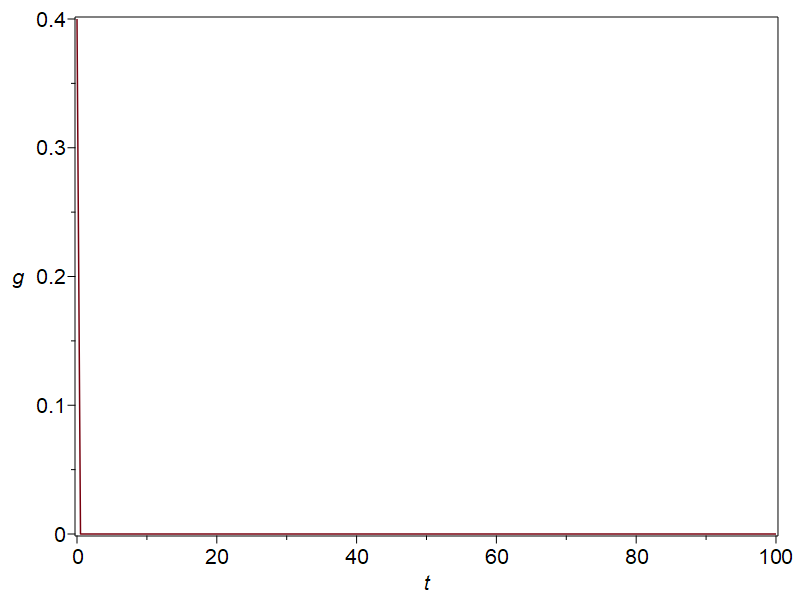

In [149]:
plots[odeplot]( numsol, [t, g(t)], t=0..100 );